# AE and MLP experiments with real data
### Streamlined data input
### The file AE02 has the final versions for the paper
### Here attempt:
- batch solutions
- larger learning rate for P_mat
- maybe SVG

# 1. Read in UTD19 data

Use python environment "ox" or "final_proj_torch"<br>

Permanent link:
https://doi.org/10.3929/ethz-b-000437802<br>

Rights / license:
Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International<br>

Loder, A., Ambühl, L., Menendez, M. and Axhausen, K.W. (2020) UTD19: Urban traffic data
from 40 cities, , , Institute for Transport Planning and Systems (IVT), ETH Zurich, Zurich.


In [1]:
import pandas as pd
import geopandas
import numpy as np
import cvxpy as cvx
import osmnx as osmnx
import networkx as nx
import matplotlib.pyplot as plt

### Data directory

In [2]:
data_dir = "../UTD2019/"
counts_file = "utd19_u - Copy.csv"
detectors_file = "detectors_public - Copy.csv"
links_file = "links.csv"

### Hard-coded list of cities in the dataset

### City to analyze

In [3]:
# city = "all" to read in original dataset (6GB) and write out each city's dataset separately
city="melbourne"
city_file = "counts_"+city+".csv"

## 1A. Read in counts

In [4]:
if(city=="all"):
    data = pd.read_csv("C:/Users/jkhac/Documents/AML/Project resources and readings/Transportation/UTD2019/utd19_u - Copy.csv")
    count_data = pd.read_csv(data_dir + counts_file)
else:
    print("Reading in data for " + city)
    count_data = pd.read_csv(data_dir + city_file)

Reading in data for melbourne


## 1B. Read in the network links with detectors on them for all cities
- linkid links to detectors dataframe: type int64
- linkid signifies a <i>lane</i> of traffic
- used in UTD19 to determine if the detector is near an intersection in order to correct density measurements
### linkid is not the same as in the OSM network. Thus this link dataframe may not be useful at all
- piece is a spatial feature number and = 1
- group is group number of that spatial feature
- lat/lon refer to waypoint location (waypoint is OSM jargon for a point)
- order is the order of the waypoint sequence (indicating flow direction)
- missing value flag is unknown. Check for NaN, nan, Inf, inf, NA, na, ...

In [5]:
link_data = pd.read_csv(data_dir + links_file)

In [6]:
link_data.head()

long        lat  order  piece  linkid  group  citycode
0  10.891016  48.361079      1      1       0    0.1  augsburg
1  10.890894  48.360993      2      1       0    0.1  augsburg
2  10.890642  48.360853      3      1       0    0.1  augsburg
3  10.890404  48.360719      4      1       0    0.1  augsburg
4  10.889994  48.360497      5      1       0    0.1  augsburg

In [7]:
link_data.dtypes

long        float64
lat         float64
order         int64
piece         int64
linkid        int64
group       float64
citycode     object
dtype: object

### Make a dataframe of links for city that is being analyzed

In [8]:
city_link_data=link_data.loc[link_data["citycode"]==city]

### Check the link dataset for missing values

In [9]:
#No missing values of linkid
np.where(pd.isna(link_data["linkid"]))

(array([], dtype=int64),)

## 1C. Read in attributes of the detectors
- Note the variable types were not specified at reading
- limit, lanes, linkid should be int
- missing values may be NA or Inf or blanks need to check all
- bordeaux, constance, utrecht have blank linkid's

In [10]:
detectors_data=pd.read_csv(data_dir + detectors_file)

### Check data types in detectors dataFrame and check detectors for missing or bad-value data

### Make a dataframe of detectors only for the city being analyzed and drop rows where no linkid
- linkid is useful later for finding the orientation of the link of the detector
- to get it onto the correct lane

In [11]:
detectors_data = detectors_data[~detectors_data.linkid.isna()]
#df[~df['this_column'].isna()]

### Drop the variable "limit" (speed limit) because it often has NaN and it's not needed

In [12]:
city_detectors_data=detectors_data[detectors_data["citycode"]==city]
city_detectors_data.drop(columns=["limit"])

detid    length       pos    fclass               road   citycode  \
13574   K4476.D1  0.086145  0.020738  tertiary      Bourke Street  melbourne   
13575   K4576.D5  0.113111  0.019706  tertiary  Exhibition Street  melbourne   
13576   K4576.D6  0.116698  0.020620  tertiary  Exhibition Street  melbourne   
13577  K4576.D10  0.212780  0.015236  tertiary     Collins Street  melbourne   
13578   K4576.D2  0.223094  0.023529  tertiary     Collins Street  melbourne   
...          ...       ...       ...       ...                ...        ...   
15199       2128  0.156109  0.000000  tertiary       Power Street  melbourne   
15200       2129  0.195684  0.000000     trunk          City Road  melbourne   
15201       2130  0.190658  0.000000     trunk          City Road  melbourne   
15202       2131  1.202346  0.000000     trunk   Alexandra Avenue  melbourne   
15203       2132  1.161623  0.000000     other                NaN  melbourne   

       lanes  linkid        long        lat  
13574    1.0   862.0  144.948762 -37.818452  
13575    1.0   343.0  144.971430 -37.813794  
13576    1.0   344.0  144.971401 -37.813805  
13577    1.0   345.0  144.971175 -37.814092  
13578    1.0   342.0  144.971878 -37.813996  
...      ...     ...         ...        ...  
15199    1.0  2128.0  144.961654 -37.823538  
15200    1.0  2129.0  144.963250 -37.823050  
15201    1.0  2130.0  144.963373 -37.823227  
15202    1.0  2131.0  144.970273 -37.820673  
15203    1.0  2132.0  144.970272 -37.821074  

[1630 rows x 10 columns]

In [13]:
city_detectors_data=city_detectors_data[city_detectors_data.detid.isin(list(count_data.detid))]

## Adjust the data type of some columns -- only works if the NaN have been removed

In [14]:
#city_detectors_data["limit"]=city_detectors_data["limit"].astype("int64")
city_detectors_data["lanes"]=city_detectors_data["lanes"].astype("int64")
city_detectors_data["linkid"]=city_detectors_data["linkid"].astype("int64")

In [15]:
print(f"The number of detectors: {city_detectors_data.shape[0]} and links from UTD19: {city_link_data.shape[0]}")

The number of detectors: 954 and links from UTD19: 5153


# 2. Data quality
## 2A. Examine the counts data

### Figure out the missing data flags: max and min (only relevant on entire counts dataset)

### The bad data flag is not noted in the data release documentation. From tests with the entire counts dataset:

In [16]:
# speed is nan and linkid is blank. the "missing" or "null" value in pandas is nan
flow_bad=99999
occ_bad=999.99
error_bad=1

In [17]:
print(f"variable   good    bad        isnull")

good=(count_data[count_data["flow"]!=flow_bad]).size
bad=(count_data[count_data["flow"]==flow_bad]).size
isnull=(count_data[count_data["flow"].isnull()]).size
print(f"flow       {good}   {bad}    {isnull}")

good=(count_data[count_data["occ"]!=occ_bad]).size
bad=(count_data[count_data["occ"]==occ_bad ]).size
isnull=(count_data[count_data["occ"].isnull()]).size
print(f"occ        {good}   {bad}    {isnull}")

good=(count_data[count_data["speed"].notnull()]).size
bad=(count_data[count_data["speed"].isnull()]).size
print(f"speed      {good}   {bad}    {bad}")

good=(count_data[count_data["error"]!=error_bad]).size
bad=(count_data[count_data["error"]==error_bad]).size
isnull=(count_data[count_data["error"].isnull()]).size
print(f"error      {good}   {bad}    {isnull}")

variable   good    bad        isnull
flow       10958792   0    0


occ        10958792   0    10958792
speed      0   10958792    10958792
error      9314096   1644696    9314096


### For calculations we only need the flow.
### Speed may be useful as a calibration or initial condition but it doesn't seem to be reliable
### Occupancy (occ) is the fraction of time a vehicle is passing over a sensor and is not necessary for calculations
### Error is supposed to be 0 (good) or 1 (bad) but doesn't seem to be reliable

## Max count of up to 10,000 should be acceptable as real data (personal communication with Lukas Ambühl 4.2023)

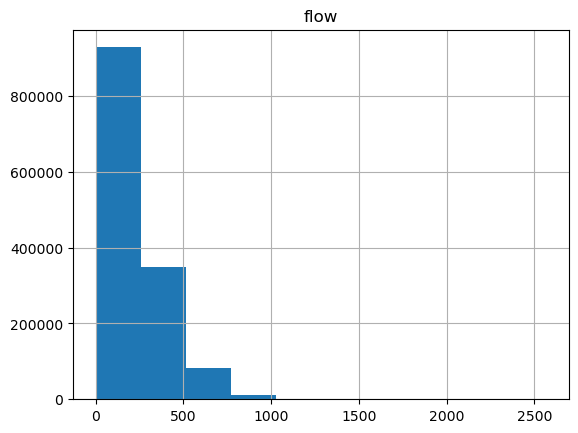

In [18]:
ax1=count_data.hist(column=["flow"])

# 3. Read in the city road network (geographically embedded graph model) from disk
## First, use "Download_OSM.ipynb" to download, simplify and save the city network
Boeing, G. 2017. "OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks." Computers, Environment and Urban Systems 65, 126-139. doi:10.1016/j.compenvurbsys.2017.05.004<br>

In [19]:
import os
path = os.path.join(data_dir,"OSM")
print(path)

../UTD2019/OSM


### Uncomment to download the graph from OSM, otherwise load from local directory
- This should be coded with error handling:
- look for city graph file on local dir
- if not found, look up city in table and get corresponding OSM PLACE_NAME
- download OSM graph

In [20]:
import osmnx
#city = "melbourne"

## Make a lookup table for all 40 cities for OSM with PLACE_NAME and city
#PLACE_NAME = "melbourne, England" # 47 sec to download from osm

In [21]:
graph=osmnx.io.load_graphml(filepath=os.path.join(path,city,city+".graphml"))

## Extract the nodes and edges to pandas GeoDataFrame

In [22]:
nodes, edges = osmnx.graph_to_gdfs(graph)

## Make a geodataframe for the detectors
- Prepares the detectors to be matched to edges on the graph by distance
- Subset the detectors dataframe for the city
- Remove the detectors with missing data

In [23]:
graph.graph["crs"]

'epsg:4326'

In [24]:
gdf_detectors=geopandas.GeoDataFrame(city_detectors_data, geometry=geopandas.points_from_xy(city_detectors_data.long, city_detectors_data.lat),crs=graph.graph["crs"])

## Overplot detector location on the map of the city graph to see where the sensors are
- for non-warped plot make sure both geodataframes and osmnx have "CRS" projection functions

In [25]:
pad=0.001
minx=gdf_detectors["long"].min()-pad
maxx=gdf_detectors["long"].max()+pad
miny=gdf_detectors["lat"].min()-pad
maxy=gdf_detectors["lat"].max()+pad

## Define a copy of the city graph and clip out a subgraph coinciding with the Long/Lat box containing the detectors
- osmnx.truncate.truncate_graph.b_box

In [26]:
#cropped_graph=osmnx.graph_from_bbox(miny, maxy, minx, maxx, network_type="drive")
cropped_graph = osmnx.truncate.truncate_graph_bbox(graph, maxy, miny, maxx, minx, truncate_by_edge=True)

In [27]:
cropped_graph.graph["crs"]

'epsg:4326'

In [28]:
n, e = osmnx.graph_to_gdfs(cropped_graph)

### The road types in the graph: no pedestrian zones, bicycle paths, etc.

# Assign a linkid in the road network to each detector in city_detectors_data DataFrame
### Some counters are clearly outside the road network and too far from edges
- Either the wrong lat/lon or they measure something else or they measure from a distance
- Using only the graph and the detector location we have no way of allocating these to an edge
### Threshold on distance to remove these detectors from the model
### In order to not lose the 1:1 correspondence between edge assignment and detector, do this thresholding after combining matched edges to detectors df

In [29]:
# Find the distance to the nearest edges from a point X,Y
# This is placing two detectors on the same edge sometimes
# I think these detectors should be in opposite lanes
# interpolate=None (0.5 sec), 1e-6 (56 sec), 1e-7 (cancelled after 7 mins)

det_uvk_list, dist=osmnx.distance.nearest_edges(cropped_graph, city_detectors_data["long"].tolist(), city_detectors_data["lat"].tolist(), interpolate=None, return_dist=True)

### Plot the distances between detectors and edges

Text(0.5, 1.0, 'Matched distance from detectors to edges, lat/lon units')

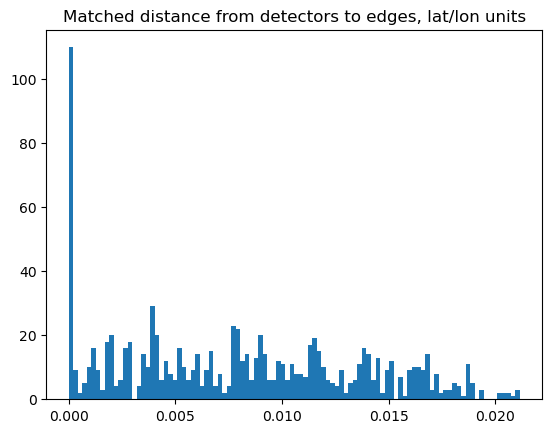

In [30]:
plt.hist(dist, bins=100)
plt.title("Matched distance from detectors to edges, lat/lon units")

## See if there is one detector per edge, >1 detector per edge, or >1 edge per detector

In [31]:
#det_uvk_list=matched_edges[0] # list of (u,v,key) for each edge that was matched to a detector, length = number of detectors
# If this is NOT 1:1 and the same u,v,key matches more than one detector, then there has been a mistake and a detector has been assigned to the wrong traffic direction
# In fact, we are not guaranteed to have matched ANY detector to the correct direction simply by a distance match
# We need to check them all for direction (later)
res = list(set([ele for ele in det_uvk_list if det_uvk_list.count(ele) > 1]))
 
# printing result
print("The following tuples (u,v,key) are duplicates in the list : " + str(res))
print("If there are duplicate edge entries then there are > 1 detector matched to an edge")

The following tuples (u,v,key) are duplicates in the list : [(6207245783, 589472358, 0), (2181268830, 1985557963, 0), (26034668, 26034664, 0), (2383211191, 2181275340, 0), (26034673, 595594352, 0), (1985557938, 576877847, 0), (6207022860, 595594347, 0), (9756035309, 9086096512, 0), (2190483594, 9086096511, 0), (8873674098, 1449431465, 0), (9512482852, 9105320429, 0), (266739054, 576876287, 0), (589472357, 9991984390, 0), (2187770692, 2190483583, 0), (846547014, 846547082, 0), (2187770699, 2383211191, 0), (2190483597, 2190483594, 0), (2190478936, 2177124606, 0), (145261423, 2177124606, 0), (767587073, 589472358, 0), (1985557963, 26034663, 0), (589403294, 26034664, 0), (2181268836, 2181268832, 0), (252588303, 1449431504, 0), (2180785582, 2180785617, 0), (1449431504, 1449431544, 0), (2187983891, 2187983881, 0), (7388026644, 1833110301, 0), (9086096518, 2180614754, 0), (2187983885, 2187983882, 0), (8633729236, 1985557938, 0), (1449431630, 741702104, 0), (741702228, 591294679, 0), (74170222

In [32]:
for j in res:
    indices = [i for i, x in enumerate(det_uvk_list) if x == j]
    for ind in indices:
     print(city_detectors_data["detid"].tolist()[ind], j)

K4455.D8 (6207245783, 589472358, 0)
K4455.D10 (6207245783, 589472358, 0)
K4455.D11 (6207245783, 589472358, 0)
K4455.D7 (6207245783, 589472358, 0)
K4455.D5 (6207245783, 589472358, 0)
K4455.D6 (6207245783, 589472358, 0)
K4455.D3 (6207245783, 589472358, 0)
K4455.D9 (6207245783, 589472358, 0)
K4455.D4 (6207245783, 589472358, 0)
K3382.D2 (6207245783, 589472358, 0)
K3382.D7 (6207245783, 589472358, 0)
K3382.D6 (6207245783, 589472358, 0)
K3382.D1 (6207245783, 589472358, 0)
K3382.D17 (6207245783, 589472358, 0)
K3382.D18 (6207245783, 589472358, 0)
K3375.D1 (6207245783, 589472358, 0)
K3375.D2 (6207245783, 589472358, 0)
K3375.D3 (6207245783, 589472358, 0)
K3375.D4 (6207245783, 589472358, 0)
K4441.D11 (6207245783, 589472358, 0)
K4441.D6 (6207245783, 589472358, 0)
K4441.D9 (6207245783, 589472358, 0)
K4441.D7 (6207245783, 589472358, 0)
K4444.D8 (6207245783, 589472358, 0)
K4444.D7 (6207245783, 589472358, 0)
K4148.D2 (6207245783, 589472358, 0)
K4148.D1 (6207245783, 589472358, 0)
K3373.D2 (6207245783, 5

## This means the detectors for opposing or parallel lanes have been associated with the same lane

- The following will ensure that each detector is assigned to the edge that is going the correct direction
- This will eliminate most of the cases where more than one detector is assigned to an edge
- Find the compass bearing of the matched edge and the linkid-order=1 of the detector.
- If the matched edge aligns in the same quadrant as the linkid-order=1 of link_data then the edge is matched correctly
- Else swap u and v of the matched edge

In [33]:
# Make a new dataframe for aligning the detectors with the correct lane direction
detector_graph_map=city_detectors_data.copy()

In [34]:
# Extract the edge u and v (point labels) from the tuple list into their own lists
edgev_match=[]
edgeu_match=[]
edge_dist=[]
for i in range(len(det_uvk_list)):
    edgeu_match.append(det_uvk_list[i][0])
    edgev_match.append(det_uvk_list[i][1])
    edge_dist.append(dist[i])

In [35]:
# Add the u and v of each edge that is associated with a detector to the detector dataframe
detector_graph_map["edgeu_match"]=edgeu_match
detector_graph_map["edgev_match"]=edgev_match
detector_graph_map["dist"]=edge_dist

### Remove detectors that are too far from road network

In [36]:
detector_graph_map=detector_graph_map[detector_graph_map.dist<0.0002]

### Put the new list of detectors (with lat/lon and edge match) into a geodataframe for plotting

<Axes: >

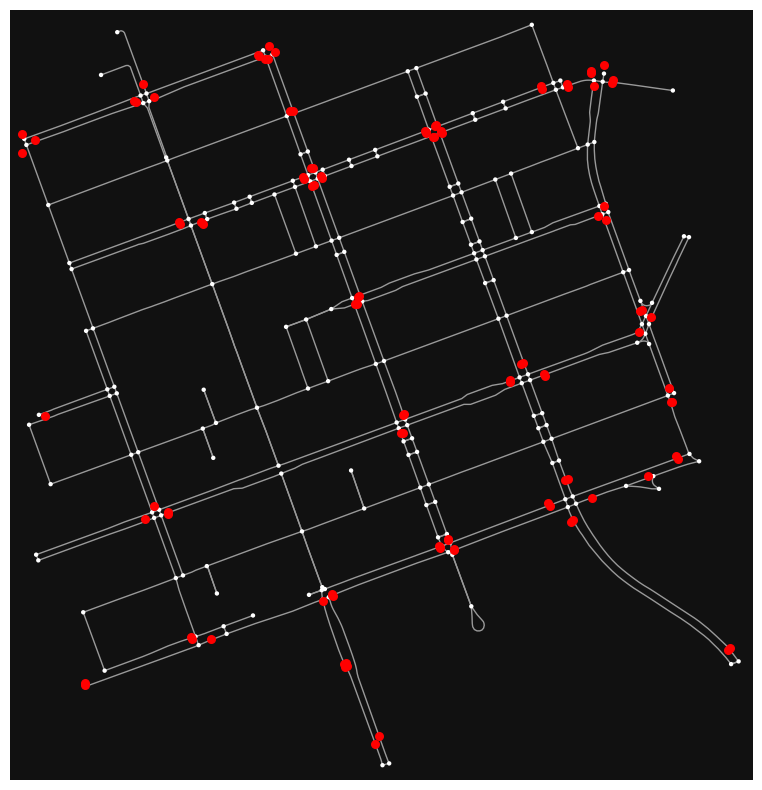

In [37]:
gdf_detector_graph_map=geopandas.GeoDataFrame(detector_graph_map, geometry=geopandas.points_from_xy(detector_graph_map.long, detector_graph_map.lat),crs=graph.graph["crs"])
figure, ax = osmnx.plot_graph(cropped_graph,show=False, node_size=10, figsize=(10,10))
gdf_detector_graph_map.plot(ax=ax, color="red", markersize=30 )

### We are assigning the detectors to links in the linkid file to determine the direction of the lane in which the detector lies
### If the linkid of a detector is not in the linkid file, this code will crash
### Since we don't otherwise know for sure which link the detector might be on
### we will drop any detector from the df which does not have a linkid in the UTD19 dataset

In [38]:
city_link_data=link_data[link_data.citycode==city]

In [39]:
detector_graph_map = detector_graph_map[detector_graph_map.linkid.isin(city_link_data.linkid) == True]

In [40]:
#for each detector id in city detector df
# Get (long,lat) from order = 1 row for detector id in the links dataframe from UTD19
#
# This is the origin of the flow on the link
# 
# Get (long, lat) from order[-1] of last waypoint as destination of flow
#
s=detector_graph_map["linkid"]
linkx1=[]
linky1=[]
linkxn=[]
linkyn=[]
for i in s:
    
    # This is the origin of the flow on the link
    #if(i in link_data.loc[link_data["linkid"]]):
        linkx1.append(link_data.loc[(link_data["linkid"]==i) & (link_data["order"]==1) & (link_data["citycode"]==city)]["long"].values[0]) # x of first waypoint
        linky1.append(link_data.loc[(link_data["linkid"]==i) & (link_data["order"]==1) & (link_data["citycode"]==city)]["lat"].values[0])# y of first waypoint
        linkxn.append(link_data.loc[(link_data["linkid"]==i) & (link_data["citycode"]==city)].values[-1][0])# x of last waypoint
        linkyn.append(link_data.loc[(link_data["linkid"]==i) & (link_data["citycode"]==city)].values[-1][1])# y of last waypoint
        # Add the x and y of the link's root node (u) to the dataframe of the detectors    
detector_graph_map["linkx1"]=linkx1
detector_graph_map["linky1"]=linky1
detector_graph_map["linkxn"]=linkxn
detector_graph_map["linkyn"]=linkyn
    #else:
     #   detector=list(detector_graph_map[detector_graph_map["linkid"] == i]["detid"])[0]
     #   #df.loc[df['column_name'] == some_value]
     #   print(f"linkid {i} is not in link file. Detector {detector} will be dropped from the dataframe")
     #   detector_graph_map.loc[detector_graph_map["linkid"] == i].drop(,inplace=True)
     #   df = df[df.line_race != 0]



In [41]:
# Need to compare the linkx1, linky1 to x,y of u on the matched edge and x,y of v on the matched edge
# So get the x,y of the edge endpoints from the n (nodes) dataframe
# Use the edgeu and edgev point name/number and match it to
# the osmid of n. The osmid of the node is in the index of geodataframe n
edgexu_match=[]
edgeyu_match=[]
edgexv_match=[]
edgeyv_match=[]

s=detector_graph_map["edgeu_match"]
for i in s:
    # This is the origin of the flow on the link
    edgexu_match.append(n.loc[(n.index==i)]["x"].values[0])
    edgeyu_match.append(n.loc[(n.index==i)]["y"].values[0])
    
s=detector_graph_map["edgev_match"]
for i in s:
    edgexv_match.append(n.loc[(n.index==i)]["x"].values[0])
    edgeyv_match.append(n.loc[(n.index==i)]["y"].values[0])

detector_graph_map["edgexu_match"]=edgexu_match
detector_graph_map["edgeyu_match"]=edgeyu_match
detector_graph_map["edgexv_match"]=edgexv_match
detector_graph_map["edgeyv_match"]=edgeyv_match


## Here match the bearing of the matched edge to the bearing of the linkid in link_data

In [42]:
# Compare bearings of link (UTD19) and edge (osmnx match)
# Initialize the edge u and v equal to the matched ones
edgexu=detector_graph_map["edgexu_match"].tolist()
edgeyu=detector_graph_map["edgeyu_match"].tolist()
edgexv=detector_graph_map["edgexu_match"].tolist()
edgeyv=detector_graph_map["edgeyv_match"].tolist()
edgeu=detector_graph_map["edgeu_match"].tolist()
edgev=detector_graph_map["edgev_match"].tolist()


# Swap u and v if the link dataset from UTD19 is aligned 180 to this
for i in range(0,len(linkx1)):
    bearing_link=osmnx.bearing.calculate_bearing(linkx1[i],linky1[i],linkxn[i],linkyn[i])
    bearing_edge=osmnx.bearing.calculate_bearing(detector_graph_map["edgexu_match"].iloc[i],detector_graph_map["edgeyu_match"].iloc[i],detector_graph_map["edgexv_match"].iloc[i],detector_graph_map["edgeyv_match"].iloc[i])
    if(np.abs(bearing_link - bearing_edge)>90.):
        print(f"flipping edge, {i}, blink, {bearing_link}, bedge, {bearing_edge}")
        print(edgeu[i],edgev[i])
        edgeu[i]=detector_graph_map["edgev_match"].iloc[i]
        edgev[i]=detector_graph_map["edgeu_match"].iloc[i]
        edgexu[i]=detector_graph_map["edgexv_match"].iloc[i]
        edgeyu[i]=detector_graph_map["edgeyv_match"].iloc[i]
        edgexv[i]=detector_graph_map["edgexu_match"].iloc[i]
        edgeyv[i]=detector_graph_map["edgeyu_match"].iloc[i]
        #print(f"flipping edge, {i}, blink, {bearing_link}, bedge, {bearing_edge}")
detector_graph_map["edgeu"]=edgeu
detector_graph_map["edgev"]=edgev
detector_graph_map["edgexu"]=edgexu_match
detector_graph_map["edgeyu"]=edgeyu_match
detector_graph_map["edgexv"]=edgexu_match
detector_graph_map["edgeyv"]=edgeyv_match
 

flipping edge, 13, blink, 347.585116450739, bedge, 166.6543300687305
2190478932 2180785617
flipping edge, 17, blink, 61.83002488141235, bedge, 240.86307559527984
1449431476 2279153639
flipping edge, 28, blink, 60.19584463962448, bedge, 346.3145503205392
26034670 589402311
flipping edge, 42, blink, 351.591020327535, bedge, 171.9291816346005
589472357 9991984390
flipping edge, 44, blink, 352.3278798478308, bedge, 171.9291816346005
589472357 9991984390
flipping edge, 50, blink, 87.23516690108112, bedge, 347.382400481132
2189497200 2189497232
flipping edge, 51, blink, 347.8633907478478, bedge, 166.95149677078257
2189497210 2187983890
flipping edge, 52, blink, 60.62805451798604, bedge, 346.64748483718716
2187983891 2187983881
flipping edge, 54, blink, 61.602311246070485, bedge, 346.64748483718716
2187983891 2187983881
flipping edge, 70, blink, 346.8856878863601, bedge, 166.9680678789085
2187770692 2190483583
flipping edge, 89, blink, 61.328067987420496, bedge, 166.62080330547263
1985557963 

In [43]:
# Clean up the dataframe
detector_graph_map=detector_graph_map.drop(["edgeu_match", "edgev_match", "linkx1", "linky1", "linkxn", "linkyn","edgexu_match","edgeyu_match","edgexv_match","edgeyv_match"],axis=1)

## Making a dict of edge (u,v,k) and detid allows setting detid as an attribute on the graph
## This may be useful or not
## A dict in this direction means there must be a 1:1 relationship between edge <--> detid
## Or else a detector will go "missing"
## Examine once again if there are still multiple detectors per edge
## Before zipping them into the following dict

In [44]:
# The key of each edge is set to 0 in the osmnx package.
uvkeys=np.zeros(len(detector_graph_map["detid"])).astype(int)
uv_tuples=list(zip(detector_graph_map["edgeu"].tolist(),detector_graph_map["edgev"].tolist(),uvkeys))

In [45]:
# See if the tuple "edgeu, edgev", the matched edges after correcting for the direction of traffic, is repeated
res2 = list(set([ele for ele in uv_tuples if uv_tuples.count(ele) > 1]))
 
# printing result
print("The following tuples (u,v,key) are duplicates in the list : " + str(res2))
print("If there are duplicate edge entries then there are > 1 detector matched to an edge")

The following tuples (u,v,key) are duplicates in the list : [(6207245783, 589472358, 0), (26034673, 595594352, 0), (2187983881, 2187983891, 0), (1985557938, 576877847, 0), (6207022860, 595594347, 0), (9756035309, 9086096512, 0), (2190483594, 9086096511, 0), (9512482852, 9105320429, 0), (589472357, 9991984390, 0), (252588303, 1449431504, 0), (1449431504, 1449431544, 0), (7388026644, 1833110301, 0), (9086096518, 2180614754, 0), (2187983885, 2187983882, 0), (8633729236, 1985557938, 0), (741702228, 591294679, 0), (741702223, 266739054, 0), (2187874241, 2190478928, 0), (9991984390, 589472357, 0), (663497749, 252588303, 0), (1449431554, 2180614752, 0), (576877857, 9512482841, 0), (576876287, 576877857, 0), (589402289, 2180614756, 0), (8633729231, 9086096516, 0), (1833110282, 2165149751, 0), (26034662, 2181268836, 0), (6381474060, 26034670, 0), (6207022859, 26034668, 0), (1985557931, 9086096518, 0), (4544002874, 26034669, 0), (846547014, 598154601, 0), (6207070036, 1985557923, 0), (9756035317

In [46]:
for j in res2:
    indices = [i for i, x in enumerate(uv_tuples) if x == j]
    for ind in indices:
     print(city_detectors_data["detid"].iloc[ind], j)

K4455.D4 (6207245783, 589472358, 0)
K4457.D4 (6207245783, 589472358, 0)
K4453.D4 (26034673, 595594352, 0)
K4455.D10 (26034673, 595594352, 0)
K4404.D5 (2187983881, 2187983891, 0)
K4404.D8 (2187983881, 2187983891, 0)
K4404.D16 (1985557938, 576877847, 0)
K4405.D2 (1985557938, 576877847, 0)
K4584.D10 (6207022860, 595594347, 0)
K4451.D2 (6207022860, 595594347, 0)
K4451.D6 (6207022860, 595594347, 0)
K1052.D4 (9756035309, 9086096512, 0)
K1052.D1 (9756035309, 9086096512, 0)
K1052.D5 (2190483594, 9086096511, 0)
K1052.D7 (2190483594, 9086096511, 0)
K4405.D9 (9512482852, 9105320429, 0)
K4405.D6 (9512482852, 9105320429, 0)
K4583.D4 (589472357, 9991984390, 0)
K4583.D2 (589472357, 9991984390, 0)
K4575.D9 (252588303, 1449431504, 0)
K4575.D2 (252588303, 1449431504, 0)
K4453.D1 (1449431504, 1449431544, 0)
K4453.D2 (1449431504, 1449431544, 0)
K4370.D1 (7388026644, 1833110301, 0)
K4370.D3 (7388026644, 1833110301, 0)
K4370.D12 (7388026644, 1833110301, 0)
K4576.D6 (9086096518, 2180614754, 0)
K4576.D3 (9086

# Final set of detectors and road network
- The useful counters (correctly georeferenced to graph edges)
    - The validity of the counts from the detectors will be checked later
- The graph of a manageable size (number of nodes/edges/routes)

In [47]:
gdf_detector_graph_map=geopandas.GeoDataFrame(detector_graph_map, geometry=geopandas.points_from_xy(detector_graph_map.long, detector_graph_map.lat),crs=graph.graph["crs"])

<Axes: >

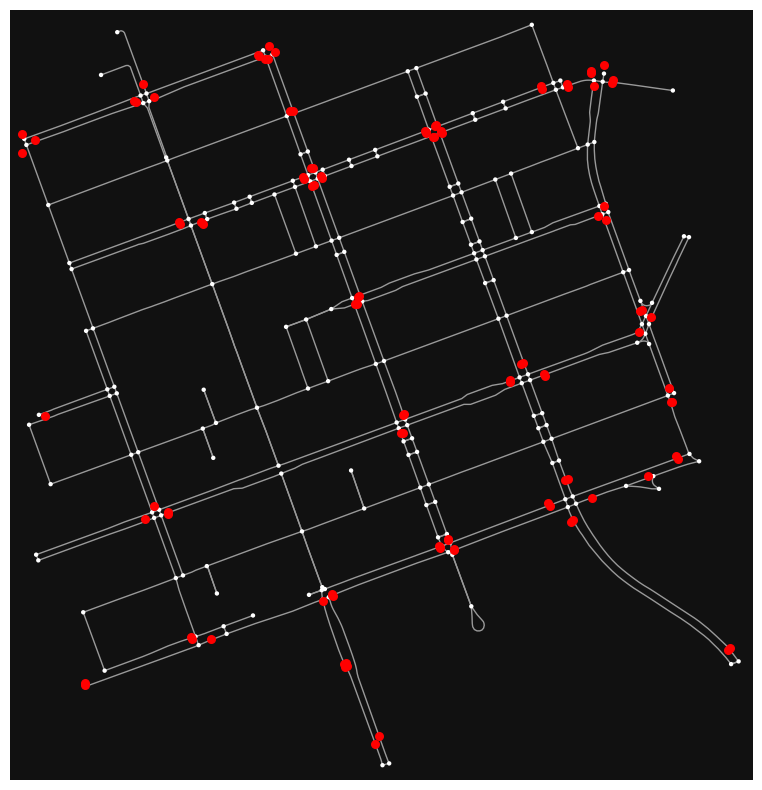

In [48]:
figure, ax = osmnx.plot_graph(cropped_graph,show=False, node_size=10, figsize=(10,10))
gdf_detector_graph_map.plot(ax=ax, color="red", markersize=30 )
#plt.savefig(data_dir+"/OSM/"+city+"/final_network_with_counters.png")

## In real traffic networks, there is sometimes more than one detector per graph edge.
- Serve to measure road speed and congestion along the road link
- For the purposes of generating an OD matrix, only the volumes are necessary
- And only one detector need be kept per edge
- The "zip" command to make a dict of {(u,v,k): detid} will take only one.
- For the purposes of estimating the total counts on an edge, check if the detectors are measuring multiple lanes
- If so, assign the one with more lanes to the edge.

In [49]:
edge_detector_dict=dict(zip(uv_tuples, detector_graph_map["detid"].tolist()))

## Set detector ID in the edge attributes. The documentation says "G,name,values" but the function needs "G,values,name" !

In [50]:
# set_edge_attributes(graph,name, values ) # values (u,v,key) dict or list
import networkx as nx
nx.set_edge_attributes(cropped_graph, edge_detector_dict, "detid")
#osmnx.set_edge_attributes(cropped_graph, edge_detector_dict, "detid")

# Continue here with the cropped graph and its attributes

#### Add speed/travel time
- https://github.com/gboeing/osmnx-examples/blob/main/notebooks/02-routing-speed-time.ipynb

In [51]:
# impute speed on all edges missing data
cropped_graph = osmnx.add_edge_speeds(cropped_graph)

In [52]:
# calculate travel time (seconds) for all edges
cropped_graph = osmnx.add_edge_travel_times(cropped_graph)

In [53]:
# see mean speed/time values by road type
weighted_edges = osmnx.graph_to_gdfs(cropped_graph, nodes=False)
#edges,nodes=osmnx.graph_to_gdfs(cropped_graph)
weighted_edges["highway"] = weighted_edges["highway"].astype(str)
weighted_edges.groupby("highway")[["length","speed_kph", "travel_time"]].mean().round(1)

length  speed_kph  travel_time
highway                                       
living_street     92.8       18.9         18.0
primary           12.2       34.1          1.3
secondary        112.8       40.4          9.9
secondary_link    14.4       34.1          1.5
tertiary          68.6       40.7          6.0
tertiary_link     14.4       40.0          1.3
unclassified      78.0       30.6          9.4

In [54]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(cropped_graph)[1]
dest = list(cropped_graph)[192]
route1 = osmnx.shortest_path(cropped_graph, orig, dest, weight="length")
route2 = osmnx.shortest_path(cropped_graph, orig, dest, weight="travel_time")

### nx k shortest paths between O,D
- In one example (melbourne cropped from 1 to 99) nx found different fastest route than osmnx

In [55]:
from itertools import islice

def k_shortest_paths(G, source, target, k, weight=None):

    return list(

        islice(nx.shortest_simple_paths(G, source, target, weight=weight), k)

    )
paths=[]
for path in k_shortest_paths(nx.DiGraph(cropped_graph), orig, dest, 4, weight="travel time"):

    #print(path)
    paths.append(path)

# Make the objects that are needed for the calculation of OD flow

- nodes from n.index
- edges from e or edges (speeds and tt here)
- edges_uv from edges.index
- G from cropped_graph
- edge_weights from G edge "travel time"
- nodes_xy from n
- countkeys edges with counts from edge_detector_dict.keys()
- counts from countkeys and count_data



In [56]:
# Using map() and lambda
def listOfTuples(l1, l2):
    return list(map(lambda x, y:(x,y), l1, l2))


In [57]:
# node names
nodes = n.index
# edge names
edges=list(cropped_graph.edges(data=False))
# edges_uv
edge_uv=list(cropped_graph.edges(data=False))
# edge_weights
edge_weights=[]
for next in list(cropped_graph.edges(data="travel_time")):
    edge_weights.append(next[-1])
# nodes_xy
# Driver Code
list1 = n["x"]
list2 = n["y"]
node_xy=(listOfTuples(list1, list2))

# The graph needs u,v,k in edge key. The code I wrote for the toy model just u,v

In [58]:
edge_weights_dict=dict(zip(edge_uv,edge_weights))
edge_weights_dict_for_graph=dict(zip(weighted_edges.index, weighted_edges["travel_time"]))
edge_labels_dict=dict(zip(edges,edge_uv))
node_xy_dict = dict(zip(nodes,node_xy))

In [59]:
G=cropped_graph
nx.set_node_attributes(G,node_xy_dict,name="pos")
nx.set_edge_attributes(G,edge_weights_dict_for_graph,name="weight")

### See this link for total route travel time and also for plottign heatmaps of road speed (change to OD and route flow)
- https://max-coding.medium.com/osmnx-part-1-loading-data-from-open-street-maps-and-finding-shortest-route-between-two-points-5bb073b0a27d

In [60]:
edge_travel_time = osmnx.utils_graph.get_route_edge_attributes(
    G, route1, 'travel_time') 
route_travel_time = sum(edge_travel_time)
print("Travel time route 1 in minutes:", route_travel_time/60)

Travel time route 1 in minutes: 0.9349999999999999


# $Y_i$

### Remove the dropped detectors from the counts_data dataframe

In [61]:
keeplist=list(edge_detector_dict.values())
print(keeplist)

['K4576.D6', 'K4576.D9', 'K4576.D3', 'K4577.D2', 'K4577.D3', 'K4580.D6', 'K4580.D3', 'K4580.D7', 'K4575.D9', 'K4575.D2', 'K4575.D7', 'K4575.D5', 'K2901.D6', 'K2901.D10', 'K2902.D10', 'K2902.D8', 'K2902.D5', 'K2902.D2', 'K2902.D6', 'K2902.D3', 'K2024.D3', 'K2024.D2', 'K2903.D3', 'K2903.D13', 'K2903.D11', 'K2903.D7', 'K4444.D11', 'K4444.D7', 'K4444.D4', 'K4444.D1', 'K4593.D4', 'K4593.D2', 'K4593.D6', 'K4595.D4', 'K4595.D1', 'K4598.D2', 'K4560.D2', 'K4560.D5', 'K4560.D10', 'K4560.D7', 'K4563.D6', 'K4563.D4', 'K4564.D2', 'K2921.D6', 'K2921.D7', 'K2921.D4', 'K2921.D3', 'K4561.D1', 'K4561.D3', 'K4561.D10', 'K4562.D8', 'K4530.D1', 'K2904.D6', 'K2904.D10', 'K2912.D2', 'K2912.D3', 'K2920.D8', 'K2920.D7', 'K2920.D3', 'K2920.D9', 'K2920.D4', 'K2922.D1', 'K2922.D4', 'K2922.D6', 'K2931.D1', 'K2932.D4', 'K4528.D6', 'K4531.D5']


In [62]:
cropped_count_data=count_data[count_data.detid.isin(keeplist)]

In [63]:
cropped_count_data['day'] = cropped_count_data['day'].astype(str)
cropped_count_data['interval'] = cropped_count_data['interval'].astype(int)
cropped_count_data['flow'] = cropped_count_data['flow'].astype(float)
cropped_count_data['detid'] = cropped_count_data['detid'].astype(str)
cropped_count_data['time'] = pd.to_datetime(cropped_count_data['day']).values.astype(np.int64) // 10 ** 9 + cropped_count_data['interval']

C:\Users\jkhac\AppData\Local\Temp\ipykernel_13216\1870342441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_count_data['day'] = cropped_count_data['day'].astype(str)
C:\Users\jkhac\AppData\Local\Temp\ipykernel_13216\1870342441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_count_data['interval'] = cropped_count_data['interval'].astype(int)
C:\Users\jkhac\AppData\Local\Temp\ipykernel_13216\1870342441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [64]:
cropped_count_data.head()

day  interval     detid   flow  occ  error       city  speed  \
4536  2018-02-12         0  K2024.D2  204.0  NaN    NaN  melbourne    NaN   
4537  2018-02-12       900  K2024.D2  124.0  NaN    NaN  melbourne    NaN   
4538  2018-02-12      1800  K2024.D2   84.0  NaN    NaN  melbourne    NaN   
4539  2018-02-12      2700  K2024.D2   80.0  NaN    NaN  melbourne    NaN   
4540  2018-02-12      3600  K2024.D2   84.0  NaN    NaN  melbourne    NaN   

            time  
4536  1518393600  
4537  1518394500  
4538  1518395400  
4539  1518396300  
4540  1518397200

In [65]:
print(f'The detectors have data from {min(cropped_count_data["day"])} until {max(cropped_count_data["day"])}')

The detectors have data from 2018-02-12 until 2018-02-26


In [66]:
counts=cropped_count_data.pivot(index="detid", columns="time", values="flow").values

### Pivoting the flows into a matrix of time versus detid causes nan
- There are no nan's in flow
- But some detid's don't have observations in some time slots
- They are forced to have SOME entry in the pivot table (matrix) and this is set to nan

### Row 19 has almost no valid measurements across time slices: drop this detector

In [67]:
# Row 19 detector has nearly all missing data: drop
print(cropped_count_data["detid"].unique()[19])
id=cropped_count_data["detid"].unique()[19]

K2920.D4


# Remake the I x Nt counts matrix with cleaned data
### NOTE in the pivot table the detectors and the time slices are sorted alphabetically

In [68]:
edge_detector_dict=dict(zip(uv_tuples, detector_graph_map["detid"].tolist()))
#value_drop=cropped_count_data["detid"].unique()[19]
key_drop=(list(edge_detector_dict.keys())[list(edge_detector_dict.values()).index(id)]) 
del edge_detector_dict[key_drop]
keeplist=list(edge_detector_dict.values())
cropped_count_data=count_data[count_data.detid.isin(keeplist)]
cropped_count_data['day'] = cropped_count_data['day'].astype(str)
cropped_count_data['interval'] = cropped_count_data['interval'].astype(int)
cropped_count_data['flow'] = cropped_count_data['flow'].astype(float)
cropped_count_data['detid'] = cropped_count_data['detid'].astype(str)
cropped_count_data['time'] = pd.to_datetime(cropped_count_data['day']).values.astype(np.int64) // 10 ** 9 + cropped_count_data['interval']
counts=cropped_count_data.pivot(index="detid", columns="time", values="flow").values

C:\Users\jkhac\AppData\Local\Temp\ipykernel_13216\1218948610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_count_data['day'] = cropped_count_data['day'].astype(str)
C:\Users\jkhac\AppData\Local\Temp\ipykernel_13216\1218948610.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_count_data['interval'] = cropped_count_data['interval'].astype(int)
C:\Users\jkhac\AppData\Local\Temp\ipykernel_13216\1218948610.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

### Not many nan's still need to treat them: remove detector, remove time slices, interpolate values

### Get column indices containing nan's

In [69]:
s=np.argwhere(np.isnan(counts)).flatten()
col_ind=[]
for i in range(0,len(s),2):
    col_ind.append(s[i])
col_ind=np.array(col_ind)
col_ind=np.unique(col_ind)
print(col_ind)

[ 0  1 12 13 14 15 16 17 18 23 24 30 31 32 33 34 35 47 57]


In [70]:
interp_counts=pd.DataFrame(counts.T)
interp_counts.head()

0     1    2     3    4      5      6      7      8    9   ...    57  \
0  204.0  48.0  4.0  52.0  0.0  148.0  124.0  160.0  148.0  0.0  ...  80.0   
1  124.0  40.0  4.0  48.0  0.0  136.0   80.0  112.0  132.0  0.0  ...  48.0   
2   84.0  36.0  8.0  52.0  0.0   96.0   80.0   92.0  140.0  0.0  ...  32.0   
3   80.0  44.0  4.0  16.0  0.0   88.0   80.0   68.0  140.0  0.0  ...  32.0   
4   84.0  16.0  8.0  28.0  4.0   64.0   76.0   92.0  136.0  0.0  ...  24.0   

      58     59     60     61    62    63     64    65    66  
0  140.0  100.0  128.0  144.0  60.0  92.0  140.0  44.0  44.0  
1  164.0   64.0  132.0  136.0  56.0  80.0  104.0  20.0  40.0  
2  152.0   64.0  112.0   92.0  60.0  72.0  116.0  32.0  52.0  
3  148.0  116.0   92.0   88.0  60.0  72.0   92.0  28.0  28.0  
4  116.0   64.0  100.0   72.0  44.0  80.0  108.0  20.0  40.0  

[5 rows x 67 columns]

In [71]:
means=interp_counts.mean(axis=0)
print(means[47])

279.34075104311546


In [72]:
#interp_counts.interpolate(method='pad', axis=1, inplace=True, columns=list(col_ind))
interp_counts.fillna(means,axis=0,inplace=True)

In [73]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(interp_counts[47])

0       208.000000
1       140.000000
2       148.000000
3       124.000000
4       180.000000
5       128.000000
6        68.000000
7       140.000000
8       128.000000
9        84.000000
10      100.000000
11       96.000000
12      100.000000
13      112.000000
14      116.000000
15      112.000000
16       96.000000
17       76.000000
18      104.000000
19      104.000000
20      128.000000
21      100.000000
22      128.000000
23      176.000000
24      204.000000
25      240.000000
26      316.000000
27      256.000000
28      376.000000
29      444.000000
30      416.000000
31      488.000000
32      464.000000
33      500.000000
34      440.000000
35      444.000000
36      436.000000
37      452.000000
38      404.000000
39      432.000000
40      416.000000
41      460.000000
42      360.000000
43      448.000000
44      444.000000
45      448.000000
46      476.000000
47      468.000000
48      408.000000
49      396.000000
50      408.000000
51      424.000000
52      416.

Text(0.5, 1.0, 'Melbourne Sensor K1052.D4 with interpolated counts')

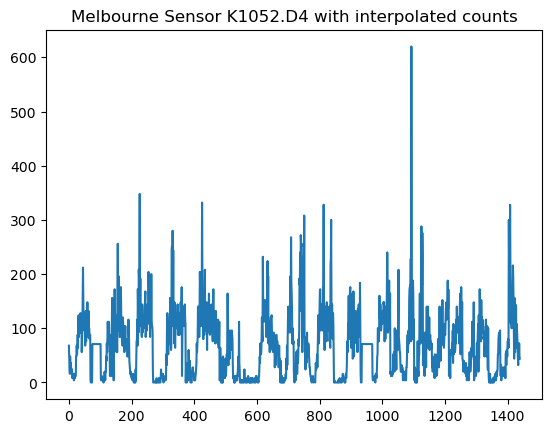

In [74]:
dename=list(pd.Series.sort_values(city_detectors_data["detid"]))[23]
plt.plot(range(0,1440),interp_counts[23])
plt.title("Melbourne Sensor "+dename+" with interpolated counts")
#plt.savefig(data_dir+"/OSM/"+city+"/interpolated_counts.png")

# Make the final counts matrix with cleaned up values
### Make associated indices for the pivot rows and columns

In [75]:
counts=(np.array(interp_counts).T)
counts_detectors=list(pd.Series.sort_values(city_detectors_data["detid"]))
counts_time=list(pd.Series.sort_values(cropped_count_data["time"]).unique())
print(counts.shape)
print(counts_detectors)
print(counts_time)

(67, 1440)
['K1036.D1', 'K1036.D3', 'K1036.D4', 'K1037.D1', 'K1037.D2', 'K1037.D3', 'K1038.D1', 'K1038.D2', 'K1038.D3', 'K1038.D4', 'K1038.D5', 'K1038.D6', 'K1039.D1', 'K1039.D2', 'K1039.D3', 'K1039.D4', 'K1039.D6', 'K1045.D5', 'K1051.D1', 'K1051.D4', 'K1051.D5', 'K1052.D1', 'K1052.D2', 'K1052.D4', 'K1052.D5', 'K1052.D7', 'K1052.D9', 'K1057.D1', 'K1057.D3', 'K1057.D6', 'K1057.D8', 'K1059.D2', 'K1061.D12', 'K1061.D2', 'K1061.D3', 'K1061.D4', 'K1061.D5', 'K1061.D7', 'K1061.D8', 'K1061.D9', 'K1065.D2', 'K1065.D3', 'K1065.D4', 'K1066.D1', 'K1066.D3', 'K1066.D4', 'K1066.D5', 'K2024.D1', 'K2024.D2', 'K2024.D3', 'K2901.D10', 'K2901.D6', 'K2901.D7', 'K2901.D9', 'K2902.D10', 'K2902.D11', 'K2902.D12', 'K2902.D2', 'K2902.D3', 'K2902.D5', 'K2902.D6', 'K2902.D7', 'K2902.D8', 'K2902.D9', 'K2903.D10', 'K2903.D11', 'K2903.D13', 'K2903.D14', 'K2903.D2', 'K2903.D3', 'K2903.D6', 'K2903.D7', 'K2904.D10', 'K2904.D6', 'K2904.D7', 'K2904.D9', 'K2907.D11', 'K2907.D12', 'K2907.D2', 'K2907.D3', 'K2907.D4', 'K29

### The countkeys are the (u,v) of each edge which has counts available

In [76]:
countkeys=list(edge_detector_dict.keys())
counts_dict=dict(zip(countkeys,counts[:,:]))
print(countkeys)

[(589402289, 2180614756, 0), (9086096518, 2180614754, 0), (1449431554, 2180614752, 0), (8633729231, 9086096516, 0), (1985557931, 9086096518, 0), (2187874241, 2190478928, 0), (2190478930, 2190478924, 0), (2180785617, 2190478932, 0), (2180614756, 1449431476, 0), (6167357881, 1449431467, 0), (8873674098, 1449431465, 0), (2279153639, 1449431476, 0), (589472357, 9991984390, 0), (6207022859, 26034668, 0), (6381474060, 26034670, 0), (6207022860, 595594347, 0), (6775859251, 589402311, 0), (6381564384, 595594348, 0), (589402311, 26034670, 0), (595594347, 595594348, 0), (1449431465, 1449431464, 0), (1449431504, 1449431544, 0), (26034673, 595594352, 0), (4544002874, 26034669, 0), (9756035317, 1985557927, 0), (6207070036, 1985557923, 0), (9991984390, 589472357, 0), (6207245783, 589472358, 0), (767587073, 589472358, 0), (2189497243, 589472357, 0), (2279153639, 2189497210, 0), (2189497232, 2189497200, 0), (2187983890, 2189497210, 0), (2187983881, 2187983891, 0), (2187983885, 2187983882, 0), (2190478

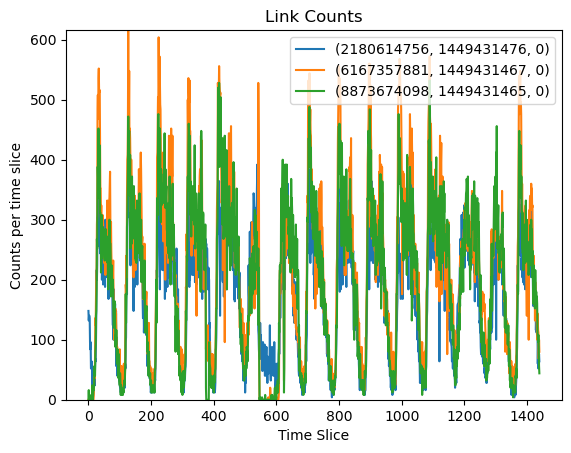

In [77]:
import matplotlib.pyplot as plt
x=list(range(0,counts.shape[1]))
ymax=0
for ii in range(8,11):#range(counts.shape[0]):
    y=counts[ii,:]
    y[np.where(np.isnan(y))]=0
    if(ymax < np.max(y)):
        ymax=np.max(y)
    plt.plot(x,counts[ii,:],label=str(list(counts_dict.keys())[ii]))
plt.ylim(0,ymax)
plt.xlabel("Time Slice")
plt.ylabel("Counts per time slice")
plt.legend()
plt.title("Link Counts")
#plt.savefig(data_dir+"/OSM/"+city+"/sample_counts_all.png")
plt.show()
plt.close()

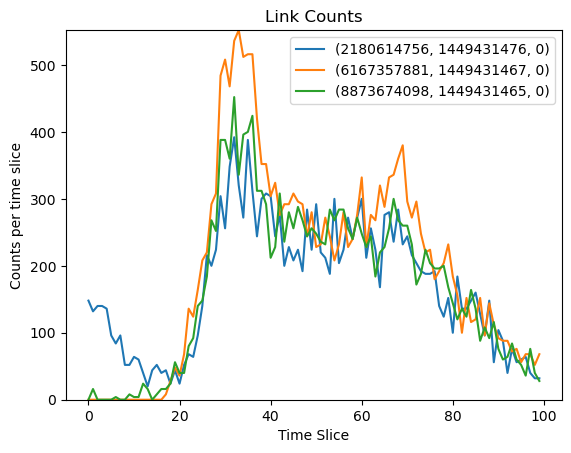

In [78]:
import matplotlib.pyplot as plt
x=range(0,100)
ymax=0
for ii in range(8,11):#range(counts.shape[0]):
    y=counts[ii,0:100]
    y[np.where(np.isnan(y))]=0
    if(ymax < np.max(y)):
        ymax=np.max(y)
    plt.plot(x,counts[ii,0:100],label=str(list(counts_dict.keys())[ii]))
plt.ylim(0,ymax)
plt.xlabel("Time Slice")
plt.ylabel("Counts per time slice")
plt.legend()
plt.title("Link Counts")
#plt.savefig(data_dir+"/OSM/"+city+"/sample_counts_day.png")
plt.show()
plt.close()

# Routes between O's and D's.
- one list of routes as edge sequences
- one list of routes as node sequences
- note that a dict of OD_pairs to routes must accomodate several routes per OD_pair later on
    - the "zip" can be replaced by an iterator over OD_Pairs, add a list of routes to the OD_Pair key

# $O, D$

## In order to keep the size of the calculation manageable
## do not use all the nodes as origins and destinations
### Choosing only nodes of degree 1 (dead ends) and 2 (corners/dead ends) makes an interesting and manageable model

In [79]:
degs = [lis[1] for lis in list(G.degree())]
ns = [lis[0] for lis in list(G.degree())]
len(ns)
#print(np.array(ns)[np.argwhere(np.array(degs)<3)].tolist())
#ns=ns[np.argwhere(np.array(degs)<3)]
#len(ns)
origins=np.array(ns)[np.argwhere(np.array(degs)<3)].flatten().tolist()
destinations=origins
#print(origins)

(array([  7.,   0.,  22.,   0.,  43.,   0., 127.,   0.,   6.,   6.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

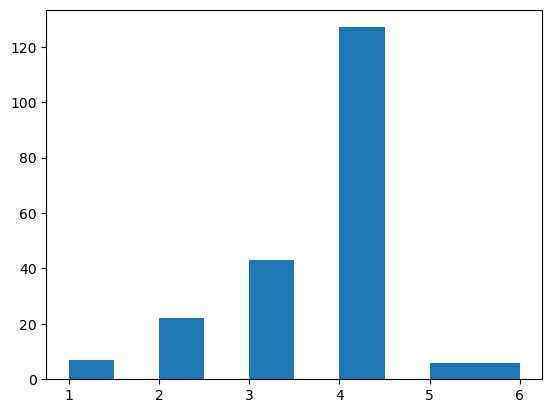

In [80]:
plt.hist(degs)

In [81]:
#origins=nodes#["A"]#nodes
#destinations=nodes#["F"]
od_pairs=[]
for o in origins:
   for d in nx.dfs_postorder_nodes(G,source=o):
    if((o!=d) and (d in destinations)):
        od_pairs.append((o,d))
#print(od_pairs)
print(len(od_pairs))

319


In [82]:
od_route_n_dict={}
od_route_e_dict={}

# For a perfect result we need all possible routes between O and D
### This is prohibitively expensive to calculate, even on small networks
### Set max number of routes per OD here
# Route choice uses weighted paths with travel time
### Using 2 routes per OD covers more edges, makes a less sparse result
### This reduces the number of routes with zero flow vs. using 1 route per OD


### Routes from networkx library are lists of nodes. Make a list of edges, as well

In [97]:
# routes as sequence of nodes
routes_n=[]
routes_e=[]
#
# use 2 as a standard reference run
#
nroutes_per_od=10
i=0
for od in od_pairs:
    if(i%100 == 0):
        print(f"Searching paths for od {od} {i/len(od_pairs)}")
    i+=1
    relist=[]
    rnlist=[]
    for path in k_shortest_paths(nx.DiGraph(cropped_graph), od[0], od[1], nroutes_per_od, weight="travel time"):
        rnlist.append(path)
        elist=[]
        for j in range(len(path)-1):
            e=(path[j], path[j+1])
            #print(f"e {e}")
            elist.append(e)
        #print(f"elist {elist}")
        relist.append(elist)
        #print(f"relist {relist}")
    od_route_e_dict[od]=relist
    routes_e.append(relist)
    od_route_n_dict[od]=rnlist
    routes_n.append(rnlist)

Searching paths for od (114607252, 174792857) 0.0
Searching paths for od (277089929, 9105320429) 0.31347962382445144
Searching paths for od (2177124604, 2177124606) 0.6269592476489029
Searching paths for od (3313134384, 9105320429) 0.9404388714733543


In [98]:
od_route_names_dict={}
route_names=[]
for od in od_pairs:
    od_route_names=[]
    for i in range(0,len(od_route_e_dict[od])):
        string=((od[0],od[1],str(i)))
        od_route_names.append(string)
        route_names.append(string)
    od_route_names_dict[od]=tuple(od_route_names)


In [99]:
import pickle 

with open(data_dir+"/OSM/"+city+"/od_route_names_dict_"+str(nroutes_per_od)+".pkl", "wb") as f:
    pickle.dump(od_route_names_dict, f)

### Have to flatten the routes_e and routes_n lists in order to assign them to route_names

In [252]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [253]:
# dict of origins and routes
routes_e_dict=dict(zip(route_names,flatten(routes_e)))# route names, edge sequence (tuple u,v)
routes_n_dict=dict(zip(route_names,flatten(routes_n)))# route names, node sequence (u)

In [254]:
# route costs
routes_c_dict={}
for rn in route_names:
    es=routes_e_dict[rn]
    lc=[]
    for e in es:
 #       print(f"e {e}")
        c=edge_weights_dict[e]
        lc.append(c)
    routes_c_dict[rn]=lc
print(routes_c_dict)

{(114607252, 174792857, '0'): [9.8, 8.1, 2.4, 10.2, 0.9, 1.2, 20.2, 13.1, 13.9, 22.5], (114607252, 174792857, '1'): [9.8, 8.1, 2.4, 10.2, 0.9, 1.2, 20.2, 20.0, 9.9, 16.1, 6.8, 17.3, 13.9, 22.5], (114607252, 174792857, '2'): [9.8, 8.1, 2.4, 10.2, 0.9, 9.7, 10.0, 1.1, 1.2, 1.1, 10.0, 9.7, 20.2, 13.1, 13.9, 22.5], (114607252, 174792857, '3'): [9.8, 8.1, 2.4, 10.2, 0.9, 1.2, 20.2, 20.0, 1.4, 19.5, 9.9, 38.8, 2.8, 16.1, 6.8, 17.3, 13.9, 22.5], (114607252, 174792857, '4'): [9.8, 8.1, 2.4, 10.2, 0.9, 1.2, 20.2, 20.0, 9.9, 10.1, 1.1, 7.3, 2.4, 5.3, 6.8, 28.3, 27.9, 13.9, 22.5], (114607252, 174792857, '5'): [9.8, 8.1, 2.4, 10.2, 0.9, 9.7, 10.0, 1.1, 1.2, 1.1, 10.0, 9.7, 20.2, 20.0, 9.9, 16.1, 6.8, 17.3, 13.9, 22.5], (114607252, 174792857, '6'): [9.8, 8.1, 2.4, 10.2, 0.9, 1.2, 20.2, 20.0, 9.9, 10.1, 3.8, 3.8, 7.3, 2.4, 5.3, 6.8, 28.3, 27.9, 13.9, 22.5], (114607252, 174792857, '7'): [9.8, 8.1, 2.4, 10.2, 0.9, 1.2, 20.2, 20.0, 9.9, 16.1, 13.6, 4.3, 3.8, 7.3, 2.4, 5.3, 6.8, 28.3, 27.9, 13.9, 22.5],

In [255]:
# Make OD flows out of the route flows by summing over route flows for each OD

def od_flow_from_route_flow(od_pairs, route_flows):
    
 # Make OD flows out of the route flows by summing over route flows for each OD
    I=x.value.shape[1]
    J=len(od_pairs)
    j=0
    i_r=0
    od_flow=np.zeros((I))
    od_flow_matrix=np.zeros((J,I))
    for od in od_pairs:
        od_flow=0
        rs=od_route_names_dict[od]
        for r in rs:
            od_flow=od_flow+route_flows[i_r,:]
            print(j,i_r,r,od_flow, route_flows[i_r,:])
            i_r+=1
        od_flow_matrix[j,:]=od_flow
        j+=1
    return(od_flow_matrix)

# The network coverage if using only nodes of degree 1 and 2 for origins and destinations
### With 2 routes per OD, all the edges are sampled which have detectors on them
- Detectors with valid counts are blue dots
- Other dots are origins and destinations
- 627 routes are rainbow colors

# Adjacency matrix (link-path incidence matrix) A=aij
- counted edges/links versus routes they are on
- 0,1 definition used by Vardi(1996) and Hazelton(2015)

# This adjacency matrix is I (num counted edges) x J (num routes between OD's)

In [256]:
I=len(countkeys)
J=len(route_names)
print(I,J)
aij=np.zeros((I,J))
i=0
for e in countkeys:#I
 #   print(f"e {e} etype {type(e)}")
    j=0
    for rn in route_names:#J
 #       print(f"rn {rn} rntype {type(rn)}")
        rs=routes_e_dict[rn]
        for r in rs:
            #print(i,j,e,r)
            if((e[0],e[1]) == r):# countkeys is (u,v,key) tuple. just need u and v
 #               print(i,j,e,r)
                aij[i,j]=1
        j+=1
    i+=1
        

67 7665


In [257]:
aij# each column is a route between an OD pair J and each row has 1 if a link I is on the route

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### The aij matrix is sparse

# Matrix of <i>all</i> edges which are on routes a2ij
- Map of all edges/links and the routes they are on
- 0,1
- Use to calculate the flows on non-measured links along the routes
- After the OD flows are calculated

In [258]:
I=len(edge_labels_dict.keys())
J=len(route_names)
a2ij=np.zeros((I,J))
pi1=np.zeros((I,J))
i=0
for e in edge_labels_dict.values():#I
    j=0
    for rn in route_names:#J
        rs=routes_e_dict[rn]
        for r in rs:
#            print(i,j,e,r)
            if((e[0],e[1]) == r):
                a2ij[i,j]=1
                pi1[i,j]=edge_weights[i]
        j+=1
    i+=1

In [259]:
print(a2ij)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [260]:
a2ij.shape

(377, 7665)

### For each time slice, Y is counts (dim m x 1) = A (dim m x n) * X (dim n x 1), m<n .
- Need to find X the OD flow
- m is the number of edges with counts on them
- n is the number of routes between OD
- dimension 1 becomes K for K time slices
- Here, K is 1440 slices of 0.25 hrs each = 360 hr = 15 d

In [261]:
print(aij.shape, counts.shape)

(67, 7665) (67, 1440)


# Prepare some helper functions for calculating route travel times

In [262]:
# Average travel time on all routes from node curr to node d

def get_av_t(G,curr, d):
    #paths=nx.all_simple_paths(G,curr,d)
    paths=k_shortest_paths(nx.DiGraph(cropped_graph), curr, d, 2, weight="travel time")
    av_t=0
    sum=0
    for path in map(nx.utils.pairwise,paths):       
        for i in list(path):
 #           print(f"i {i} weight {edge_weights_dict[i]}")
            tp=edge_weights_dict[i]
  #          print(f"tp {tp}")
            av_t=av_t+tp
  #          print(f"tav {av_t}")
        sum+=1
#    print(f"sum {sum}")
    if(sum>0):
        av_t=av_t/sum#else there are no paths (curr = d)
    print(f"avt {av_t}")
    return(av_t)

In [263]:
# Travel time on routes from node curr to node d

def get_tr(route,curr, d):
    tr=0
    es=routes_e_dict[route]
    start_i=0
    for e in es:
        if(e[0])==curr:
 #           print(f"get_tr {e},{curr}")
            start_i = start_i
            break
        else:
            start_i+=1
    #print(f"start_i {start_i}")        
    for i in range(start_i,len(es)):# add link costs along the route from curr node (start) to the end
        tr=tr+(edge_weights_dict[es[i]])
    print(f"tr {tr}")
    return(tr)

# Helper dict of all the nodes in the set of routes on the OD pairs

In [264]:
#
# Get all the nodes in all possible routes for each OD, flatten and make unique
# Loses the route sequence however
#
#for all od choose relation rel
od_nodes_dict={}
for od in od_pairs:
    od_nodes=[]
# get all routes on rel
    rs=od_route_names_dict[od]
    for r in rs:
        od_nodes.append(routes_n_dict[r])
    xx=flatten(od_nodes)
    xx_set=set(xx)
    od_nodes=list(xx_set)
    print(f"od {od} has {len(rs)} routes over nodes {od_nodes}")
    od_nodes_dict[od]=od_nodes

od (114607252, 174792857) has 25 routes over nodes [9086096512, 2187983875, 9086096517, 9086096518, 6381512709, 176721287, 2187983881, 2187983882, 245533066, 114607245, 245532558, 2187983885, 2187983886, 2187983890, 2187983891, 114607252, 1985557912, 174792857, 1985557931, 589402289, 1449431476, 2188404536, 2188404539, 4544002877, 176721271, 2187874240, 2187874242, 2187770693, 176722502, 2190478922, 2190478924, 2190478926, 2190478930, 2190478932, 2190478934, 9756035286, 2190478936, 2190478937, 2190478940, 2180614754, 2180614756, 6775862757, 2279153639, 9756035309, 26051950, 26051952, 2190561008, 26034673, 2190561011, 595594352, 595594353, 595594354, 174792823, 6206786040, 26034672, 9756035316, 2189497210]
od (114607252, 174812848) has 25 routes over nodes [9086096512, 2187983875, 9086096517, 9086096518, 6381512709, 176721287, 2187983881, 2187983882, 245533066, 114607245, 245532558, 2187983885, 2187983886, 2187983890, 2187983891, 114607252, 1985557912, 174812829, 1985557931, 174812848, 

# Helper dict to list all edge tuples (u,v) on the set of routes on the OD pairs

In [265]:
#
# Get all the edges in all possible routes for each OD, flatten and make unique
# Sequence of the edges in the routes is lost
#
#for all od choose relation rel
od_edges_uv_dict={}
for od in od_pairs:
    od_edge_names=[]
    od_edges_uv=[]
# get all routes on rel
    rs=od_route_names_dict[od]
    for r in rs:
        od_edge_names.append(routes_e_dict[r])
    xx=flatten(od_edge_names)
    xx_set=set(xx)
    od_edge_names=list(xx_set)
#    print(od_edge_names)
    for en in od_edge_names:
 #       print(en)
        od_edges_uv.append(en)
    #xx=flatten(od_edges_uv)
    #xx_set=set(xx)
    #od_edges_uv=list(xx_set)
    print(f"od {od} has {len(rs)} routes over edges {od_edges_uv}")
    od_edges_uv_dict[od]=od_edges_uv

od (114607252, 174792857) has 25 routes over edges [(595594353, 245532558), (26051950, 6775862757), (595594354, 245533066), (2187770693, 2187874242), (114607252, 114607245), (2190561011, 2190561008), (245532558, 245533066), (2187874240, 2187874242), (26034672, 1985557912), (2187983886, 9756035286), (9756035309, 9086096512), (26034673, 245532558), (176722502, 176721271), (9086096518, 2180614754), (176721271, 2187874242), (26034673, 595594352), (2180614756, 1449431476), (1449431476, 2279153639), (2188404536, 2187983891), (9086096517, 26051952), (2190478937, 2190478932), (2190478930, 2190478924), (2188404539, 2188404536), (176721271, 176721287), (2187983882, 2187983891), (2190478940, 2190478937), (595594352, 595594353), (2189497210, 2187983890), (9756035316, 4544002877), (2187983875, 2187983885), (245533066, 2187770693), (2187983881, 2187983886), (26051950, 1985557931), (2190478934, 2190478936), (595594353, 595594354), (1985557931, 26051952), (2279153639, 589402289), (26051952, 2187983882

In [266]:
countkeys_uv=[]
for uvk in countkeys:
    countkeys_uv.append((uvk[0],uvk[1]))
countkeys_uv

[(589402289, 2180614756),
 (9086096518, 2180614754),
 (1449431554, 2180614752),
 (8633729231, 9086096516),
 (1985557931, 9086096518),
 (2187874241, 2190478928),
 (2190478930, 2190478924),
 (2180785617, 2190478932),
 (2180614756, 1449431476),
 (6167357881, 1449431467),
 (8873674098, 1449431465),
 (2279153639, 1449431476),
 (589472357, 9991984390),
 (6207022859, 26034668),
 (6381474060, 26034670),
 (6207022860, 595594347),
 (6775859251, 589402311),
 (6381564384, 595594348),
 (589402311, 26034670),
 (595594347, 595594348),
 (1449431465, 1449431464),
 (1449431504, 1449431544),
 (26034673, 595594352),
 (4544002874, 26034669),
 (9756035317, 1985557927),
 (6207070036, 1985557923),
 (9991984390, 589472357),
 (6207245783, 589472358),
 (767587073, 589472358),
 (2189497243, 589472357),
 (2279153639, 2189497210),
 (2189497232, 2189497200),
 (2187983890, 2189497210),
 (2187983881, 2187983891),
 (2187983885, 2187983882),
 (2190478936, 2177124606),
 (576876287, 576877857),
 (663497749, 252588303),
 (

### Helper dict of route names and the travel time (cost =c) on the route

# Calculate the finite-memory Markov P transitions from the travel times on the routes as in Figure 1 of Dey.
# P matrix is i links x j OD relations
# $P_i{^j}$ is a sum over M links per route on each OD j this of dim M+1 x M+1 as in Dey (9)
# Use only edges with counts on them
- Edge ID of counted edges in countkeys (uvk) or countkey_uv (uv)
- Library networkx returns (uv) while osmnx returns (uvk)
- This matrix is called A in Dey et al. (eqn 24)
- It is the initial routing probability: zero memory Markov routing
- The probability of a vehicle at a node to travel to all the adjacent nodes toward d
- Does not take into account what route it's on
- Djikstra algorithm chooses max

In [267]:
#
# It is correct in Dey to use J as the number of OD's
# This is smaller than the number of routes
# 
#
I=len(countkeys_uv)# all edges with counts
J=len(od_pairs)# one column per OD
pij=np.zeros((I, J))
#c_inv=np.zeros((I, J))
for j in range(len(od_pairs)):
    od=od_pairs[j]
    o=od[0]
    d=od[1]
    i=0
    for curr in countkeys_uv:# the I dimension of the pij array. curr is (o,next)
        rns = od_route_names_dict[od]
        i_n = 0
        tr=0
        av_t=0
        for name in rns:# for each route on this od sum the travel time of the edges
            av_t=av_t+np.sum(routes_c_dict[name])
        av_t=av_t/len(rns)
#        print(f"av_t {av_t}")

        # if this curr edge is in the route with the name
        # get the route travel time over this edge
        for name in rns:
            path=routes_e_dict[name]
 #           print((curr[0],curr[1]), path)
            if(((curr[0],curr[1])) in path): # if this u,v,k edge is in this route
                tr=tr+np.sum(routes_c_dict[name])
                pij[i,j]=np.exp(-2*np.abs((av_t-tr)/av_t))
#                print(f"i_n tr av_t {i_n} {tr} {av_t}")
            i_n+=1 #index the next route for this od

#        print(f"i j tr av_t p {i} {j} {tr} {av_t} {pij[i,j]}")
        i+=1 # increment the row, ie next edge with counts
#
# Each entry in pij sums to one over the routes passing through edge i
# C= sum of each time a u node is passed by a route
# Following code lists the u of each node in each edge in pij and counts its ocurrence
# Each appearance of a u corresponds to a different v so the sum is the number
# of route alternatives at each node u
# The result is actually matrix A (27) in Dey
#
c_inv=np.zeros(pij.shape[0])
tmp=[]
for i in range(0,pij.shape[0]):
    tmp.append(countkeys[i][0])
#   print(f"tmp {tmp}")
for i in range(0,len(tmp)):
    c_inv[i]=tmp.count(tmp[i])
#   print(f"c_inv ,{c_inv}")
c=1./c_inv
for i in range(0,pij.shape[0]):
      pij[i,:]=pij[i,:]*c[i]
print(c_inv)
print(pij)

                

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 1.]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.89301227e-08
  3.70005346e-07 0.00000000e+00]
 [1.24263898e-08 1.26500463e-08 2.72578569e-03 ... 0.00000000e+00
  1.36971544e-10 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.47090604e-01
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [268]:
np.max(pij)

1.0

In [269]:
np.sum(pij)

476.15132345758286

In [270]:
pij.shape

(67, 319)

# $P$ is the matrix of the probability of a vehicle on OD pair j passing over link i (Dey equation 30)
- It is a route-dependent choice of next node toward d
- Probability of choosing next node (n+1) depends on which route was taken to arrive at node (n)
- Thus a finite-memory Markov transition matrix
# !This is different and corrected from any other version!

In [271]:
#
# To acquire the P matrix (finite-memory markov transition)
# we need to multiply the edge pi's over each j in each OD column
# then sum them over all j in the OD relation
#
# for each column (j in J)
#   for each edge (i in I)
#       get edge u_v
#       find the route for j that u_v is on
#       get the pij for all these edges
#       multiply them together and add them to next result for next route in j        
#
I=len(countkeys)# all edges with counts
J=len(od_pairs)# one column per OD
P_mat=np.zeros((I,J))
for j in range(0,J):
       od=od_pairs[j]
       rs=od_route_e_dict[od]
       #print(f"rs {rs}")
       for i in range(0,I):
            ptemp=0
            e=list(countkeys_uv)[i]
 #           print(f"Running for edge {e} and od {od}")
            for r in rs:
 #             print(f"e tuple {e} r {r}")
              if(e in r):
 #               print(f"  Edge {e} in Route {r}")
                product=[]
                e_indx=r.index(e)
                #for ee in r:
                for ee_indx in range(e_indx,len(r)):
#
# Don't take all edges ee in r. Only calculate product over edges FROM (u of) edge e to destination
# So for(e to end of e's in r)
#
 #                   print(f"ee {ee} r {r}")
                    if(r[ee_indx] in list(countkeys_uv)):
                        ii=list(countkeys_uv).index(r[ee_indx])

#
# This adds the pij value of the adjacency matrix to the product of probabilities for the edges on the route to d
# Only the edges with counts can be used if the edge has to be in pij
# This can't possibly represent the total probability of choosing the route to d from current node
# because not all the links and link costs are represented. Only those with counts are represented
# Maybe this is why P_mat has such very small values?
#
                        product.append(pij[ii,j])
 
                ptemp=np.prod(product)+ptemp
 
 #       print(f"i,j, ptemp,e,od {i}, {j}, {ptemp},{e},{od}")
#        print(i,j,ptemp)
       P_mat[i,j]=ptemp


In [272]:
P_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [273]:
print(np.max(P_mat),np.sum(P_mat))

3.562910206852363e-20 6.406400263126424e-19


# The model Y = M @ X can use
### M = aij dim (n_edges_with_counts, n_routes)
### M = pij dim (n_edges_with_counts, n_od_pairs)
### M = P_mat dim (n_edges_with_counts, n_od_pairs)
### It is a question of how much information the matrix should contain to constrain the solution
### Realistic "turning probabilities" could also be used if one knew details of traffic lights, congestion queues, etc.

# aij: Model time slices of counts on measured links for all routes (each OD pair can have a different number of routes). Flows are per route, not per OD

# Try first model using aij incidence matrix rather than the Markov transition matrix of Dey

In [274]:
import torch
from torch import nn
torch_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {torch_device} device")

Using cuda device


# First AE

In [321]:
# Set run hyperparameters
# Set fixed random number seed
torch.manual_seed(42)
lrate=1e-7#1e-6 aij, 1e-7 P_mat
l1size=256#256 toy 512 melbourne MLP 256 AE
l2size=32#256 toy 1024 melbourne MLP 32 AE
n_epochs=1000#3000
l1_lambda=0.01#.01
J=aij.shape[1]# J is number of routes
#J=P_mat.shape[1]
I=aij.shape[0]# I is the number of edges with counts
#Nt=counts100.shape[1]# Nt is number of time slices
xsize=J# X output is number of routes x number of time slices
zsize=l2size
ysize=I# Number of links with counts
plttitle="Melbourne center model: "
modelname="AE_aij_test_"+str(nroutes_per_od)
batchsz=32

# Note that at each instance we input len(counts) values and expect to generate len(routes) values

In [322]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

# Initialize input weights
def w0_(size):
  w0 = size[0]
  weight= 1./np.sqrt(w0)
  #weight=1/w0
 # print(f"w0 weights {weight}")
  w0_matrix=torch.Tensor(size).uniform_(-weight,weight)
 # print(f"init weight matrix {w0_matrix.cpu()}")
  return w0_matrix

class Encoder(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, ysize=ysize, xsize=xsize, l1n=l1size, l2n=l2size):
    super().__init__()

#   Network
    
    self.linear1=nn.Linear(ysize, l1n, bias=True)
    self.linear1.weight.data = w0_(self.linear1.weight.data.size())

    self.linear2=nn.Linear(l1n, l2n, bias=True)
    self.linear2.weight.data = w0_(self.linear2.weight.data.size())
    
    self.relu=nn.ReLU()
    self.sigmoid=nn.Sigmoid()

  def forward(self, y):
    '''Forward pass'''
    
    z = self.linear1(y)
    z = self.relu(z)
    z = self.linear2(z)
    z = self.relu(z)
    return z

In [323]:
class Decoder(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, ysize=ysize, xsize=xsize, l1n=l1size, l2n=l2size):
    super().__init__()

#   Network
    
    self.linear1=nn.Linear(l2n, l1n, bias=True)
    self.linear1.weight.data = w0_(self.linear1.weight.data.size())

    self.linear2=nn.Linear(l1n, xsize, bias=True)
    self.linear2.weight.data = w0_(self.linear2.weight.data.size())
    
    self.relu=nn.ReLU()
    self.sigmoid=nn.Sigmoid()

  def forward(self, z):
    '''Forward pass'''
    
    x = self.linear1(z)
    x = self.relu(x)
    x = self.linear2(x)
    x = self.relu(x)
    return x

In [276]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

# Initialize input weights
def w0_(size):
  w0 = size[0]
  weight= 1./np.sqrt(w0)
  #weight=1/w0
 # print(f"w0 weights {weight}")
  w0_matrix=torch.Tensor(size).uniform_(-weight,weight)
 # print(f"init weight matrix {w0_matrix.cpu()}")
  return w0_matrix

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, ysize=ysize, xsize=xsize, l1n=l1size, l2n=l2size):
    super().__init__()

#   Network
    
    self.linear1=nn.Linear(ysize, l1n, bias=True)
    self.linear1.weight.data = w0_(self.linear1.weight.data.size())

    self.linear2=nn.Linear(l1n, l2n, bias=True)
    self.linear2.weight.data = w0_(self.linear2.weight.data.size())
    
    self.linear4=nn.Linear(l2n, xsize, bias=True)
    self.linear4.weight.data = w0_(self.linear4.weight.data.size())
    
    self.relu=nn.ReLU()

  def forward(self, y):
    '''Forward pass'''
    
    x = self.linear1(y)
    x = self.relu(x)
    x = self.linear2(x)
    x = self.relu(x)
    x = self.linear4(x)
    #print(f"self.linear3 {x.grad_fn}")
    x = self.relu(x)
    return x

# Train the NN
### Would be nice to have day of week, hour of day or time period additionally for a useful model
### This model calculates OD flow based on a set of counts on the road segments
### To get an integer-value model, would I have to categorize each X?



### Split train, validation, test
- splitting a time series can only be done without shuffling and without cross-validation
- however we are not estimating a time-dependent model with MLP

In [324]:
i_tr=int(0.75*(counts.shape[1]))
i_va=i_tr+int(0.2*(counts.shape[1]))
print(i_tr, i_va)

1080 1368


In [325]:
# Prepare  dataset

# Train
ytrain=torch.from_numpy(counts[:,0:i_tr]).float().to(torch_device)# leaf, not requires grad
print(f"ytrain is on device: {ytrain.get_device()}")
trainloader = torch.utils.data.DataLoader(ytrain.T, batch_size=batchsz)
#print(f"ytrain {ytrain.grad_fn} {ytrain.is_leaf}")
# Validation
yval=torch.from_numpy(counts[:,i_tr+1:i_va]).float().to(torch_device)# leaf, not requires grad
print(f"ytrain is on device: {yval.get_device()}")
valloader = torch.utils.data.DataLoader(yval.T, batch_size=batchsz)
# Test
ytest=torch.from_numpy(counts[:,i_va+1:]).float().to(torch_device)# leaf, not requires grad
print(f"ytrain is on device: {ytest.get_device()}")
testloader = torch.utils.data.DataLoader(ytest.T, batch_size=batchsz)
print(f"trainsize: {ytrain.shape[1]}, valsize: {yval.shape[1]}, testsize: {ytest.shape[1]}")


ytrain is on device: 0
ytrain is on device: 0
ytrain is on device: 0
trainsize: 1080, valsize: 287, testsize: 71


In [326]:
# Initialize the AE

enc=Encoder()
enc.to(torch_device)
dec=Decoder()
dec.to(torch_device)
#print(f"mlp is on device: {next(mlp.parameters()).device}")

print(enc)
print(dec)
  
# Define the loss function and optimizer
loss_function = nn.MSELoss()
#loss_function = nn.L1Loss()

optimizer = torch.optim.Adam(enc.parameters(), lr=lrate)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-7, max_lr=1e-5,step_size_up=15,mode="exp_range", cycle_momentum=False)
#optimizer = torch.optim.SGD(mlp.parameters(), lr=lrate)

# Run the training loop

trainloss_trace=[]
valloss_trace=[]
avtrainloss_trace=[]
avvalloss_trace=[]
yhats_train=np.zeros((ytrain.shape[1],ytrain.shape[0]))# ytrain.T*0.
out_train_cpu=np.zeros((ytrain.shape[1],J))#x.value.T*0
yhats_val=np.zeros((yval.shape[1],yval.shape[0]))#yval.T*0.
out_val_cpu=np.zeros((yval.shape[1],J))#x.value.T*0

# Set the adjacency matrix (edges x routes) or the transition matrix (edges x od's)

Atorch=torch.from_numpy(aij.T).float().to(torch_device) # Transpose adjacency matrix
#Atorch=torch.from_numpy(P_mat.T).float().to(torch_device) # Transpose adjacency matrix
    
for epoch in range(0, n_epochs): # 5 epochs at maximum
  train_epoch_loss=0.  
  val_epoch_loss=0.
  # Print epoch
  #if(epoch % 100 == 0):
  print(f'Starting epoch {epoch+1}')
    
# Train
  for i, data in enumerate(trainloader):# iterate through time steps

    inputs = data.float() # there are no targets/labels
    #print(f"inputs on device: {inputs.get_device()}")
    inputs = inputs.to(torch_device)
    #print(f"inputs cast to device: {inputs.get_device()}")
   
  # Zero the gradients
    optimizer.zero_grad()
      
  # Perform forward pass
    #print(f"ytrain[:,i] {ytrain[:,i].grad_fn} {ytrain[:,i].is_leaf}")
    z = enc(inputs)
    outputs = dec(z)
    
  # Calculate loss
    yhat = (outputs @ Atorch).to(torch_device)# grad, no leaf

  #yhat = torch.tensor(Atorch @ outputs,dtype=torch.float,requires_grad=True).to(device)# no grad, leaf
  #print(f"outputs {outputs.grad_fn} {outputs.is_leaf}")
   # print(f"yhat {yhat.grad_fn} {yhat.is_leaf}")

    loss = loss_function(yhat,inputs)
  # L1 regularization
    l1_norm = sum(torch.linalg.norm(p, 1) for p in dec.parameters())
    loss = loss + l1_lambda * l1_norm
  #loss=loss_function(outputs,targets)
  
# Perform backward pass
    loss.backward()

# Perform optimization
    optimizer.step()
    scheduler.step()
      
  # Print statistics
    train_epoch_loss += loss.item()
    trainloss_trace.append(loss.item())
    #print(loss.item())

    if(epoch==n_epochs-1):
      #yhats_train[i,:]=yhat.detach().cpu().numpy()
      #out_train_cpu[i,:]=outputs.detach().cpu().numpy()
      yhats_train=np.append(yhats_train,yhat.detach().cpu().numpy(),axis=0)
      out_train_cpu=np.append(out_train_cpu,outputs.detach().cpu().numpy(),axis=0)
  avtrainloss_trace.append(train_epoch_loss/i)

# Validation
  for i, data in enumerate(valloader):
    inputs = data.float()
    inputs = inputs.to(torch_device)
    enc.eval()
    dec.eval()
    with torch.no_grad():
      z = enc(inputs)
      outputs = dec(z)
      yhat = (outputs @ Atorch).to(torch_device)
      loss = loss_function(yhat, inputs)
# L1 regularization
      l1_norm = sum(torch.linalg.norm(p, 1) for p in dec.parameters())      
      loss = loss + l1_lambda * l1_norm
      val_epoch_loss += loss.item()
      valloss_trace.append(loss.item())
    enc.train()
    dec.train()
    valloss_trace.append(loss.item())
    if(epoch==n_epochs-1):
      #yhats_val[i,:]=yhat.detach().cpu().numpy()
      #out_val_cpu[i,:]=outputs.detach().cpu().numpy()
      yhats_val=np.append(yhats_val,yhat.detach().cpu().numpy(),axis=0)
      out_val_cpu=np.append(out_val_cpu,outputs.detach().cpu().numpy(),axis=0)
  avvalloss_trace.append(val_epoch_loss/i)

# Take out initial zero-value yhats, outputs from array initialization
yhats_train=yhats_train[ytrain.shape[1]:,:]
out_train_cpu=out_train_cpu[ytrain.shape[1]:,:]
yhats_val=yhats_val[yval.shape[1]:,:]
out_val_cpu=out_val_cpu[yval.shape[1]:,:]

# Process is complete.
print("Done training")


Encoder(
  (linear1): Linear(in_features=67, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=32, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Decoder(
  (linear1): Linear(in_features=32, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=7665, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 

In [300]:
# Initialize the MLP
#mlp=MLP(ysize,xsize,l1size,l2size)
mlp=MLP()
mlp.to(torch_device)
#print(f"mlp is on device: {next(mlp.parameters()).device}")

print(mlp)
  
# Define the loss function and optimizer
loss_function = nn.MSELoss()
#loss_function = nn.L1Loss()

optimizer = torch.optim.Adam(mlp.parameters(), lr=lrate)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-4,step_size_up=15,mode="exp_range", cycle_momentum=False)

#optimizer = torch.optim.SGD(mlp.parameters(), lr=lrate)

# Run the training loop

trainloss_trace=[]
valloss_trace=[]
avtrainloss_trace=[]
avvalloss_trace=[]
yhats_train=np.zeros((ytrain.shape[1],ytrain.shape[0]))# ytrain.T*0.
out_train_cpu=np.zeros((ytrain.shape[1],J))#x.value.T*0
yhats_val=np.zeros((yval.shape[1],yval.shape[0]))#yval.T*0.
out_val_cpu=np.zeros((yval.shape[1],J))#x.value.T*0
#

# Set the adjacency matrix (edges x routes) or the transition matrix (edges x od's)

Atorch=torch.from_numpy(aij.T).float().to(torch_device) # Transpose adjacency matrix
#Atorch=torch.from_numpy(P_mat.T).float().to(torch_device) # Transpose adjacency matrix
    
for epoch in range(0, n_epochs): # 5 epochs at maximum
  train_epoch_loss=0.  
  val_epoch_loss=0.
  # Print epoch
  #if(epoch % 100 == 0):
  print(f'Starting epoch {epoch+1}')
    
# Train
  for i, data in enumerate(trainloader):# iterate through time steps

    inputs = data.float() # there are no targets/labels
    #print(f"inputs on device: {inputs.get_device()}")
    inputs = inputs.to(torch_device)
    #print(f"inputs cast to device: {inputs.get_device()}")
   
  # Zero the gradients
    optimizer.zero_grad()
      
  # Perform forward pass
    #print(f"ytrain[:,i] {ytrain[:,i].grad_fn} {ytrain[:,i].is_leaf}")
    outputs = mlp(inputs)
    
  # Calculate loss
    yhat = (outputs @ Atorch).to(torch_device)# grad, no leaf

  #yhat = torch.tensor(Atorch @ outputs,dtype=torch.float,requires_grad=True).to(device)# no grad, leaf
  #print(f"outputs {outputs.grad_fn} {outputs.is_leaf}")
   # print(f"yhat {yhat.grad_fn} {yhat.is_leaf}")

    loss = loss_function(yhat,inputs)
  # L1 regularization
    l1_norm = sum(torch.linalg.norm(p, 1) for p in mlp.parameters())
    loss = loss + l1_lambda * l1_norm
  #loss=loss_function(outputs,targets)
  
# Perform backward pass
    loss.backward()

# Perform optimization
    optimizer.step()
    scheduler.step()
          
  # Print statistics
    train_epoch_loss += loss.item()
    trainloss_trace.append(loss.item())
    #print(loss.item())

    if(epoch==n_epochs-1):
      #yhats_train[i,:]=yhat.detach().cpu().numpy()
      #out_train_cpu[i,:]=outputs.detach().cpu().numpy()
      yhats_train=np.append(yhats_train,yhat.detach().cpu().numpy(),axis=0)
      out_train_cpu=np.append(out_train_cpu,outputs.detach().cpu().numpy(),axis=0)

  avtrainloss_trace.append(train_epoch_loss/i)

# Validation
  for i, data in enumerate(valloader):
    inputs = data.float()
    inputs = inputs.to(torch_device)
    mlp.eval()
    with torch.no_grad():
      outputs = mlp(inputs)
      yhat = (outputs @ Atorch).to(torch_device)
      loss = loss_function(yhat, inputs)
# L1 regularization
      l1_norm = sum(torch.linalg.norm(p, 1) for p in mlp.parameters())      
      loss = loss + l1_lambda * l1_norm
      val_epoch_loss += loss.item()
      valloss_trace.append(loss.item())
    mlp.train()
    valloss_trace.append(loss.item())
    if(epoch==n_epochs-1):
      #yhats_val[i,:]=yhat.detach().cpu().numpy()
      #out_val_cpu[i,:]=outputs.detach().cpu().numpy()
      yhats_val=np.append(yhats_val,yhat.detach().cpu().numpy(),axis=0)
      out_val_cpu=np.append(out_val_cpu,outputs.detach().cpu().numpy(),axis=0)

  avvalloss_trace.append(val_epoch_loss/i)

# Take out initial zero-value yhats, outputs from array initialization
yhats_train=yhats_train[ytrain.shape[1]:,:]
out_train_cpu=out_train_cpu[ytrain.shape[1]:,:]
yhats_val=yhats_val[yval.shape[1]:,:]
out_val_cpu=out_val_cpu[yval.shape[1]:,:]

# Process is complete.
print("Done training")


MLP(
  (linear1): Linear(in_features=67, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=7665, bias=True)
  (relu): ReLU()
)
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting ep

In [327]:
yhats_train.shape

(1080, 67)

In [328]:
# save torch model
torch.save(enc.state_dict(), data_dir+"/OSM/"+city+"/"+modelname+"_enc.pth")
torch.save(dec.state_dict(), data_dir+"/OSM/"+city+"/"+modelname+"_dec.pth")
#torch.save(mlp.state_dict(), data_dir+"/OSM/"+city+"/"+modelname+".pth")

#Load:

#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()


In [329]:

# save output
np.savez(data_dir+"/OSM/"+city+"/"+modelname+"_out",ytrain=ytrain.detach().cpu().numpy(), yval=yval.detach().cpu().numpy(),yhats_train=yhats_train, yhats_val=yhats_val,out_train_cpu=out_train_cpu, 
         out_val_cpu=out_val_cpu,avtrainloss_trace=avtrainloss_trace, avvalloss_trace=avvalloss_trace)
# load with np.load(filename)
np.savez(data_dir+"/OSM/"+city+"/"+modelname+"_Aij", aij=aij)
np.savez(data_dir+"/OSM/"+city+"/"+modelname+"_P_mat", P_mat=P_mat)

In [330]:
yhat.shape

torch.Size([31, 67])

# Learning Curve: The train and validation losses are strongly dependent on the samples used to train/validate
### 70/20 validation loss > train loss vs 80/20 it is flipped. At 75/20 it looks "normal"
### The reason could be due to loss_train being averaged over many iters while training;
### while loss_val is only the final model of the train iters for all val instances
### Though long training reduces loss gradually, there is no sign of overfitting causing validation loss to diverge from train loss
### Would batches >1 with batch-average training loss give a better picture and maybe produce better convergence

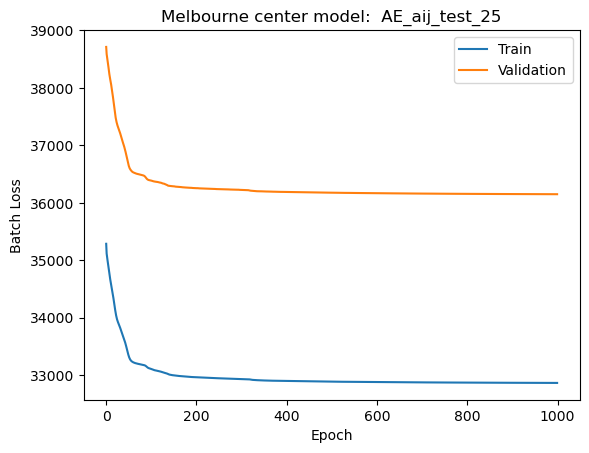

In [331]:
plt.plot(range(n_epochs),avtrainloss_trace, label="Train")
plt.plot(range(n_epochs),avvalloss_trace, label="Validation")
plt.title(plttitle+" "+modelname)
plt.ylabel("Batch Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig(data_dir+"/OSM/"+city+"/"+modelname+"_loss.png")
plt.show()
plt.close()

# Calculated vs. Measured Link Counts
- These should be reproduced perfectly from the model
- Zeros are probably detectors that are not on routes
- There are fewer zero model outputs with more routes-per-OD

In [306]:
print(yhats_train.shape,ytrain.shape,yhats_val.shape,yval.shape)

(1080, 67) torch.Size([67, 1080]) (287, 67) torch.Size([67, 287])


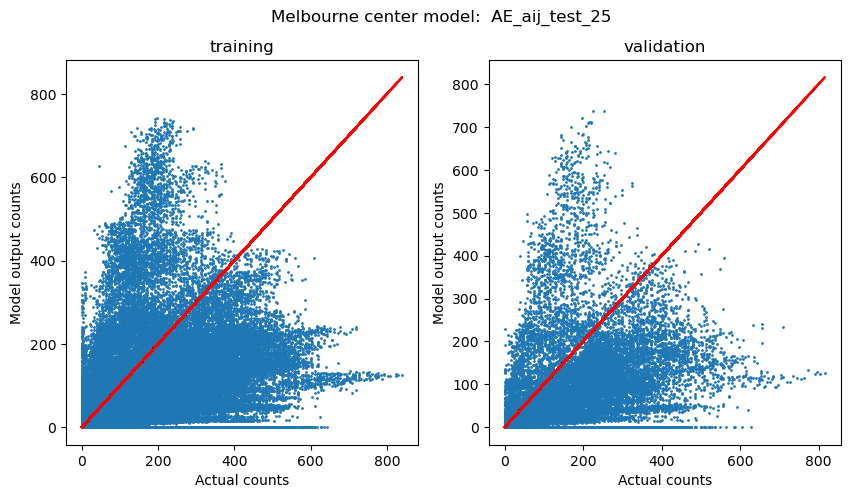

In [332]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(ytrain.detach().cpu().numpy(),yhats_train.T, s=1)
ax[0].plot(ytrain.detach().cpu().numpy(),ytrain.detach().cpu().numpy(),"-",color="red")
ax[0].title.set_text('training')
ax[0].set_ylabel("Model output counts")
ax[0].set_xlabel("Actual counts")

ax[1].scatter(yval.detach().cpu().numpy(),yhats_val.T,s=1)
ax[1].plot(yval.detach().cpu().numpy(),yval.detach().cpu().numpy(),"-",color="red")
ax[1].title.set_text("validation")
ax[1].set_ylabel("Model output counts")
ax[1].set_xlabel("Actual counts")
plt.suptitle(plttitle +" " +modelname)
plt.savefig(data_dir+"/OSM/"+city+"/"+modelname+"_counts.png")
plt.show()
plt.close()



### Which routes and what model behavior are causing this dispersion?
- Look at the predicted zero values

Text(0.5, 1.0, 'melbourne detector index where model produces zero counts, Val sample')

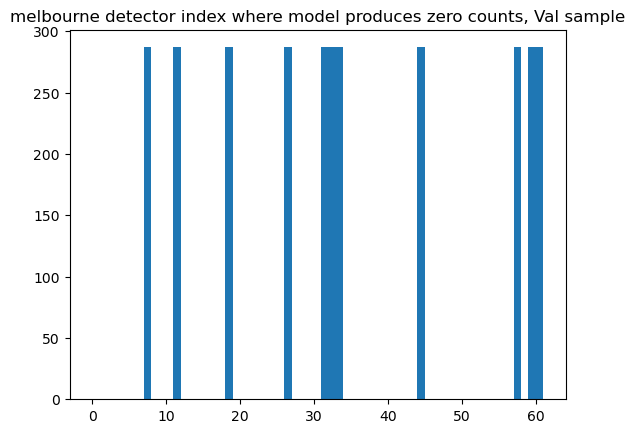

In [333]:
#import sys
#np.set_printoptions(threshold=sys.maxsize
# Plot the indices of the counters from the model with zero counts

#it=np.where(yhats_train==0.)
iv, jv=np.where(yhats_val==0.)

binz=range(0,np.max(jv)+2)

#zero_counts_train=plt.hist(jt,bins=binz)
zero_counts_val=plt.hist(jv, bins=binz)
plt.title(city+" detector index where model produces zero counts, Val sample")


In [334]:
print(jv)
print(zero_counts_val)

[ 7 11 18 ... 57 59 60]
(array([  0.,   0.,   0.,   0.,   0.,   0.,   0., 287.,   0.,   0.,   0.,
       287.,   0.,   0.,   0.,   0.,   0.,   0., 287.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 287.,   0.,   0.,   0.,   0., 287., 287.,
       287.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
       287.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0., 287.,   0., 287., 287.]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61.]), <BarContainer object of 61 artists>)


In [335]:
# Extract the index of each counter with zero counts
# They correspond to the alphabetized list of det_id from the pivot operation done on counts_cropped_data
# The list of unique detector id's from counts_cropped_data is also alphabetized
print(zero_counts_val[1][np.where(zero_counts_val[0]==287)])
zero_count_indices=zero_counts_val[1][np.where(zero_counts_val[0]==287)]
detids_without_count_estimates=(cropped_count_data["detid"].unique())[zero_count_indices.astype(int)]
print(detids_without_count_estimates)
#
# The indices aren't quite right. in yhats_val 58 has nonzero, 59 and 60 are zero
#

[ 7. 11. 18. 26. 31. 32. 33. 44. 57. 59. 60.]
['K2902.D5' 'K2903.D13' 'K2920.D3' 'K2922.D1' 'K4444.D1' 'K4444.D11'
 'K4444.D4' 'K4561.D3' 'K4577.D3' 'K4580.D6' 'K4580.D7']


In [336]:
#print(gdf_detector_graph_map[gdf_detector_graph_map["detid"]=="K2902.D5"])
#nx.get_edge_attributes(cropped_graph,name="detid")

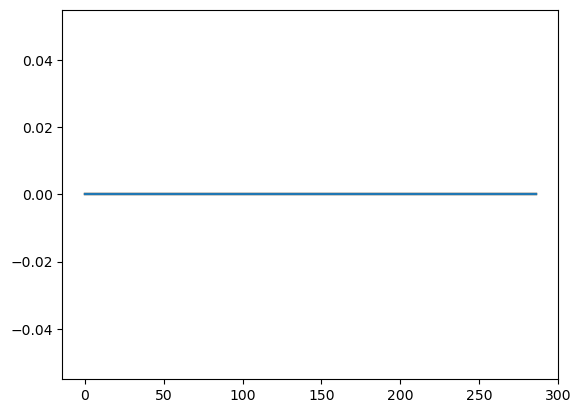

In [337]:
plt.plot(yhats_val[:,zero_count_indices.astype(int)])

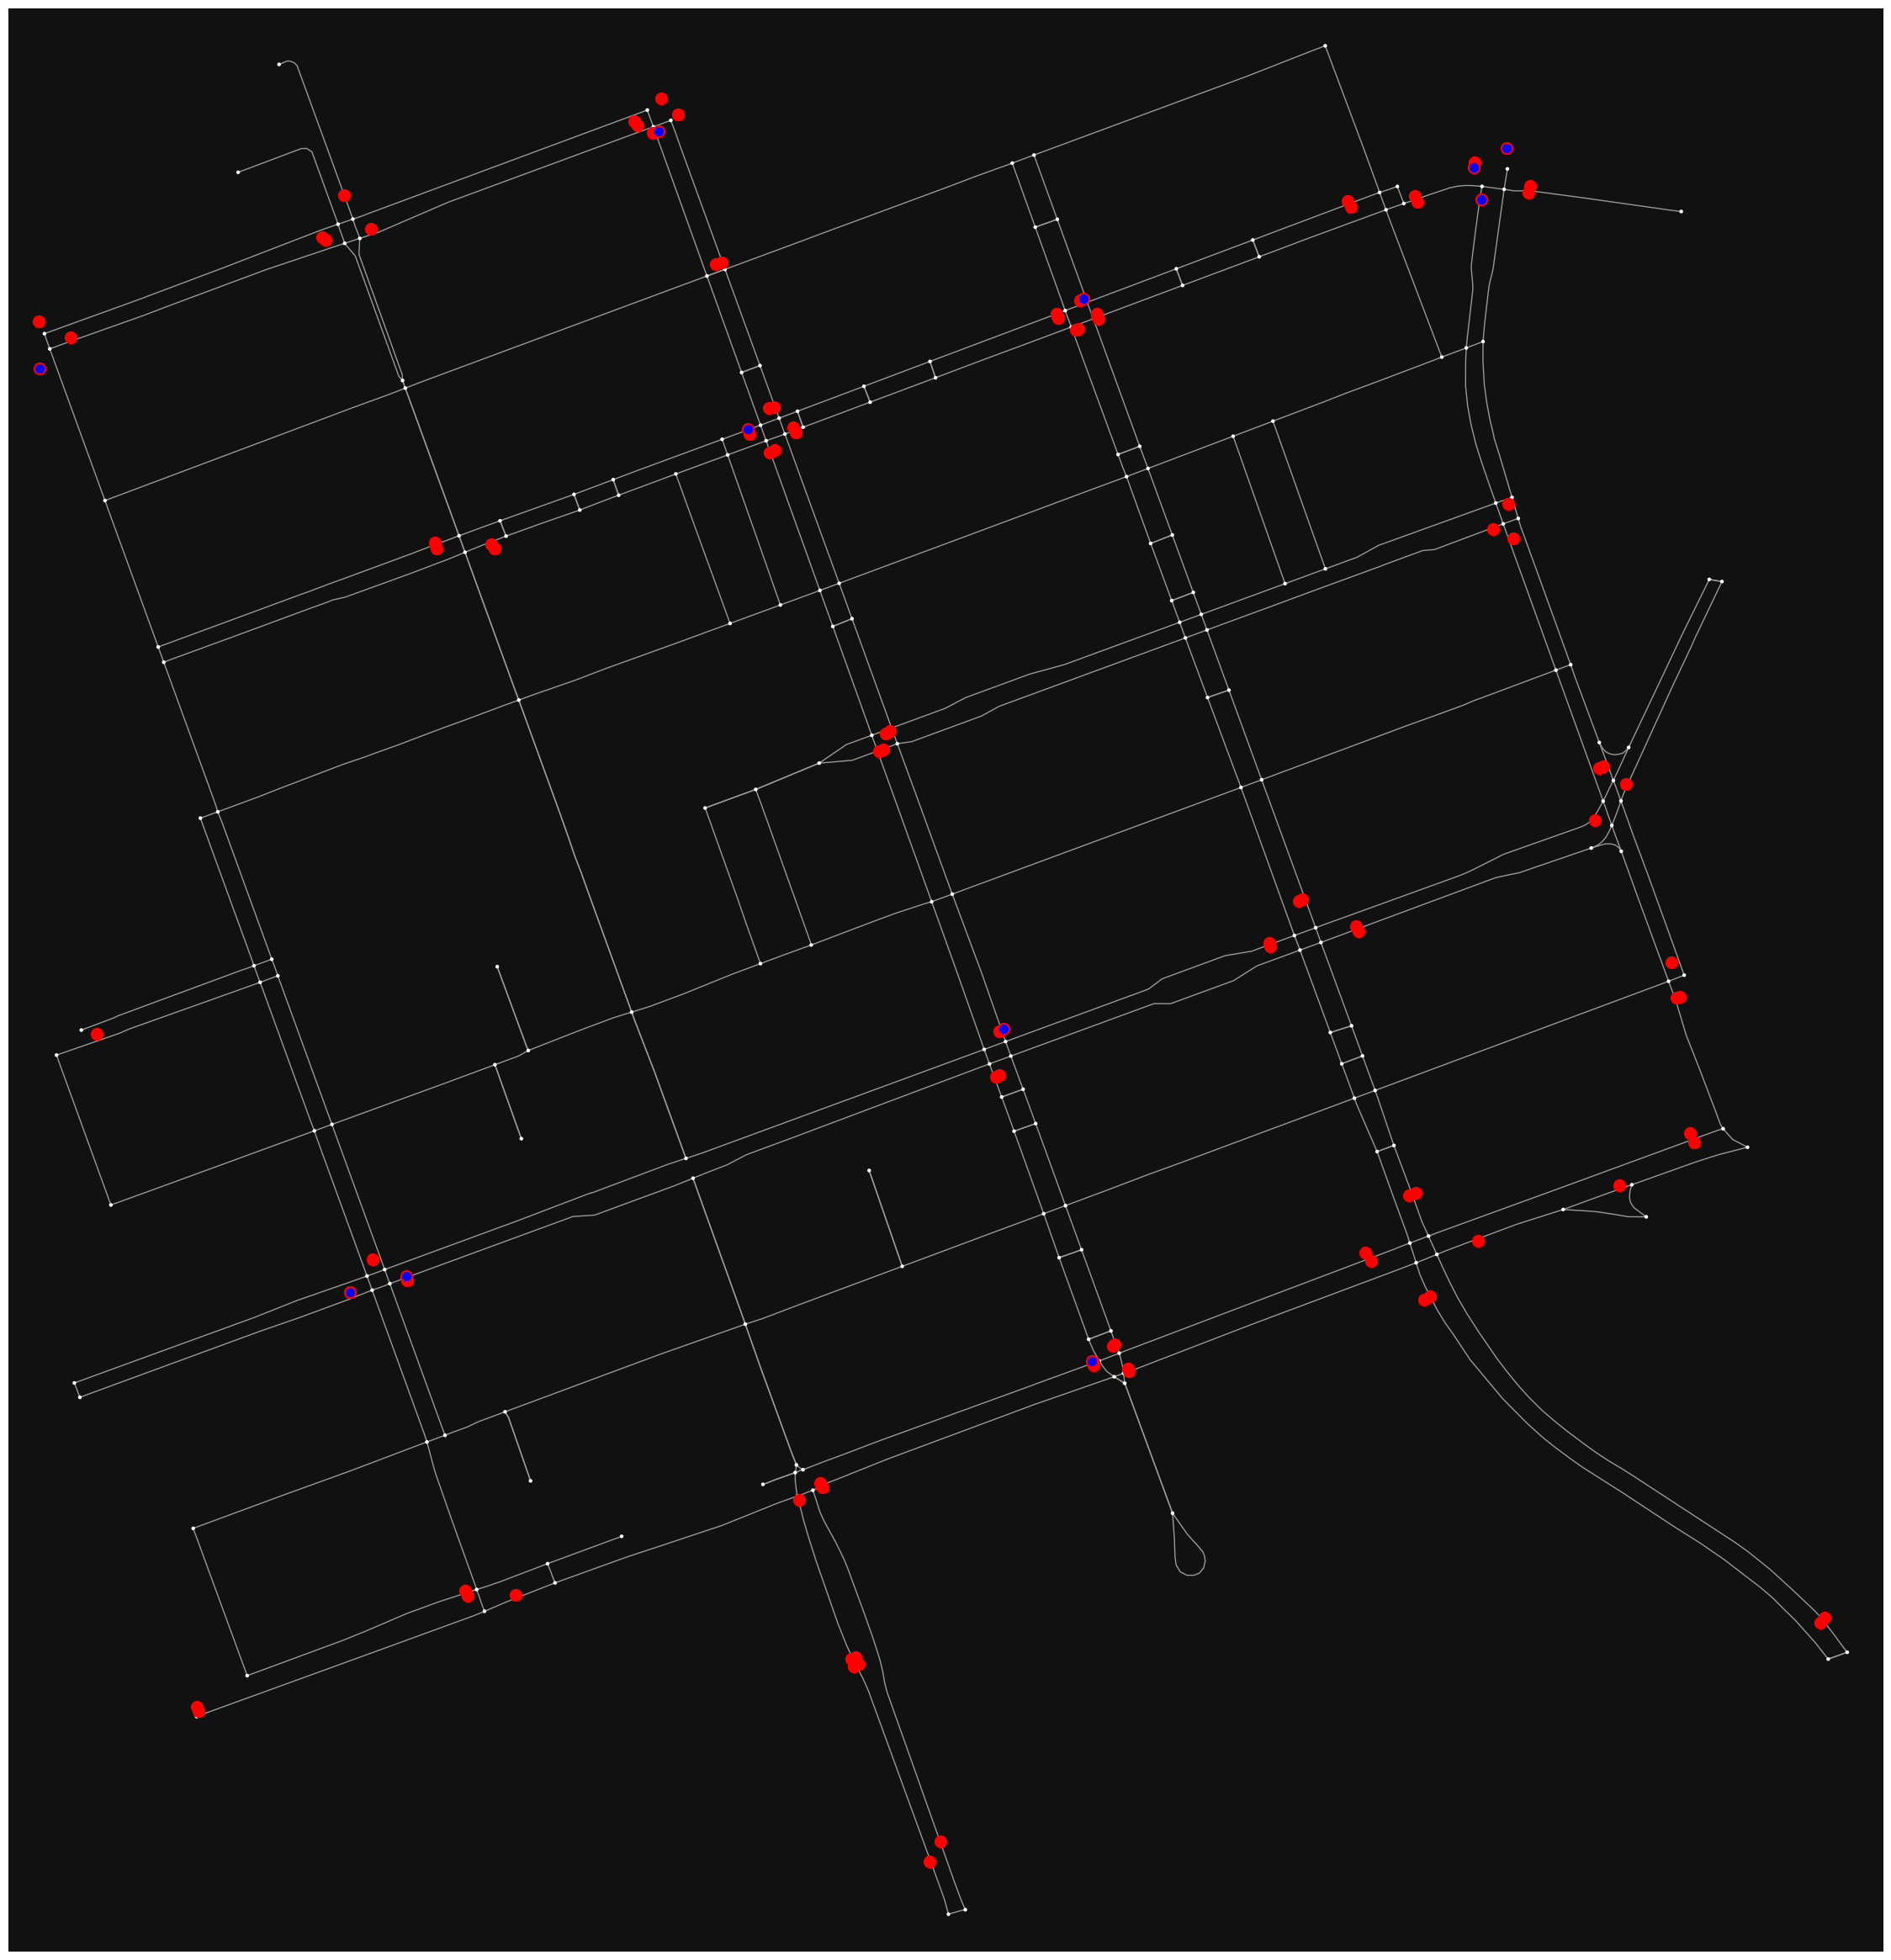

In [338]:
#gdf_detector_graph_map=geopandas.GeoDataFrame(detector_graph_map, geometry=geopandas.points_from_xy(detector_graph_map.long, detector_graph_map.lat),crs=graph.graph["crs"])
gdf_zero_detector=gdf_detector_graph_map[gdf_detector_graph_map["detid"].isin(detids_without_count_estimates)]
figure, ax = osmnx.plot_graph(cropped_graph,show=False, node_size=10, figsize=(30,30))
gdf_detector_graph_map.plot(ax=ax, color="red", markersize=100 )
gdf_zero_detector.plot(ax=ax,color="blue",markersize=50)
plt.savefig(data_dir+"/OSM/"+city+"/final_network_with_zero_counts_"+modelname+".png")
#plt.close()

### Plot the sum of flows over all time slices versus the route
- Look for routes with total zero flow

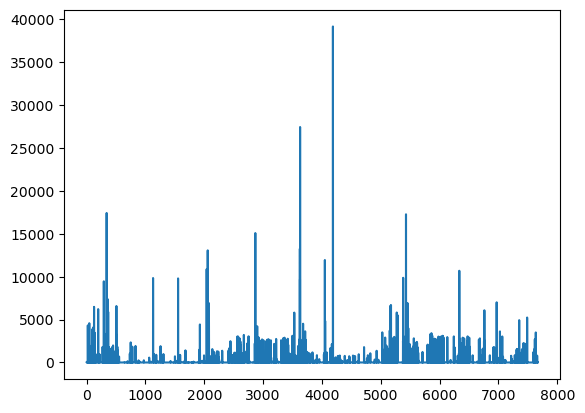

In [314]:
routes_flow=np.sum(out_val_cpu.T,axis=1)
plt.plot(routes_flow)

In [315]:
len(routes_n_dict.values())

7665

Text(0.5, 1.0, 'melbourne route index where MLP produces zero counts, Val')

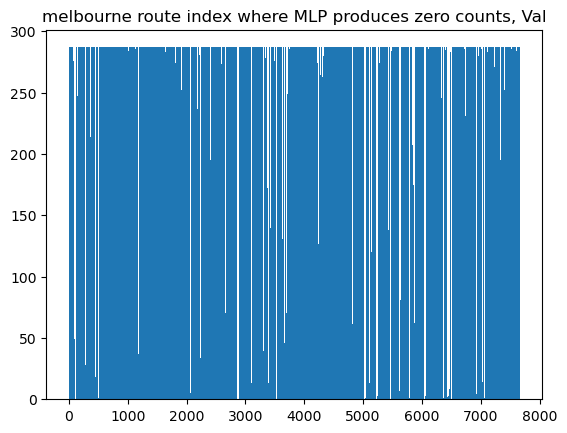

In [316]:
io, jo=np.where(out_val_cpu==0.)
binz=range(0,np.max(jo)+2)

#zero_counts_train=plt.hist(jt,bins=binz)
zero_routes_val=plt.hist(jo, bins=binz)
plt.title(city+" route index where MLP produces zero counts, Val")

In [317]:
# The indices of routes where flow is zero for all time slices
print(zero_routes_val[1][np.where(zero_routes_val[0]==287)])
zero_route_indices=zero_routes_val[1][np.where(zero_routes_val[0]==287)]
#routes_without_count_estimates=(cropped_count_data["detid"].unique())[zero_count_indices.astype(int)]
print((zero_route_indices).shape)

[2.000e+00 3.000e+00 5.000e+00 ... 7.662e+03 7.663e+03 7.664e+03]
(6299,)


### So >2500 of 3075 routes (10 routes) have zero flow at all time slices! Or 302 of 627 (2 routes). 6299 of 7665 if 25 routes
- It would be important to know which ones
- Are they systematically not assigned
- Or is it a random result that will change wtih other model parameters
- Why zero and not a small number
- Note that with 256 and 32 nodes in MLP (run by accident and not saved) only 2100 routes have zero value
- 83 OD's in the P_mat MLP and AE are zero

In [ ]:
#  # plot the routes
#  #nodez, edgez=n, e = osmnx.graph_to_gdfs(cropped_graph)
#  plotvals=list(routes_n_dict.values())
#  cols=osmnx.plot.get_colors(n=len(plotvals), cmap="brg", return_hex=True)
#  fig, ax = osmnx.plot_graph_routes(cropped_graph, routes=plotvals, route_colors= cols, route_linewidth=1, node_size=5,show=False, close=False,figsize=(30,30))
#  #for x,y, label in zip(nodez.geometry.x, nodez.geometry.y, nodez.index.tolist()):
#  #    ax.annotate(label, xy=(x,y),xytext=(10,10),textcoords="offset points",c="white",fontsize="large")
#  gdf_detector_graph_map.plot(ax=ax,color="blue", markersize=30)
#  #plt.savefig(data_dir+"/OSM/"+city+"/od_routes.png")
#  plt.show()
#  plt.close()

# Route flows from the model
- These are the most likely route flows given the underdetermined system based on link counts

In [ ]:
np.set_printoptions(suppress=True)
print(f"{np.array2string(out_train_cpu.T,precision=1, floatmode='fixed')}")
print("-----------------")
#if((x.value == None)==False):
#    print(f"{np.array2string(x.value,precision=1, floatmode='fixed')}")

# The OD flows are sums of the route flows over each OD for a_ij, they are out_xxx_cpu for P_mat
- They represent the most likely flows given the underdetermined system based on the link counts

In [298]:
(out_train_cpu.shape)

(0, 7665)

In [339]:
#np.set_printoptions(suppress=True)
print(od_pairs)
od_flow_matrix_train_ml=od_flow_from_route_flow(od_pairs,out_train_cpu.T)
od_flow_matrix_val_ml=od_flow_from_route_flow(od_pairs,out_val_cpu.T)
print(f"{np.array2string(od_flow_matrix_train_ml,precision=1, floatmode='fixed')}")
print("-----------------")
print(f"{np.array2string(od_flow_matrix_val_ml,precision=1, floatmode='fixed')}")
#if((x.value == None)==False):
#    print(od_flow_matrix_x)

[(114607252, 174792857), (114607252, 174812848), (114607252, 2177124606), (114607252, 2190483580), (114607252, 145261423), (114607252, 2181275340), (114607252, 313278043), (114607252, 846547082), (114607252, 3313134384), (114607252, 1833110279), (114607252, 9105320429), (114607252, 130015096), (114607252, 1449431464), (114607252, 26034664), (114607252, 277089929), (114607252, 2180785617), (114607252, 113536277), (130015096, 174792857), (130015096, 174812848), (130015096, 2177124606), (130015096, 2190483580), (130015096, 145261423), (130015096, 2181275340), (130015096, 313278043), (130015096, 846547082), (130015096, 3313134384), (130015096, 1833110279), (130015096, 113536277), (130015096, 9105320429), (130015096, 1449431464), (130015096, 26034664), (130015096, 277089929), (130015096, 2180785617), (130015096, 114607252), (145261423, 2177124606), (174792857, 174812848), (174792857, 2181275340), (174792857, 313278043), (174792857, 2177124606), (174792857, 2190483580), (174792857, 114607252

In [ ]:
# if P_mat the output is already od_pairs
od_flow_matrix_train_ml=out_train_cpu.T
od_flow_matrix_val_ml=out_val_cpu.T

### Hours of traffic in the counts

### The OD flows. Maybe plot them on the network

In [299]:
print(np.sum(od_flow_matrix_train_ml,axis=1).astype(int))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


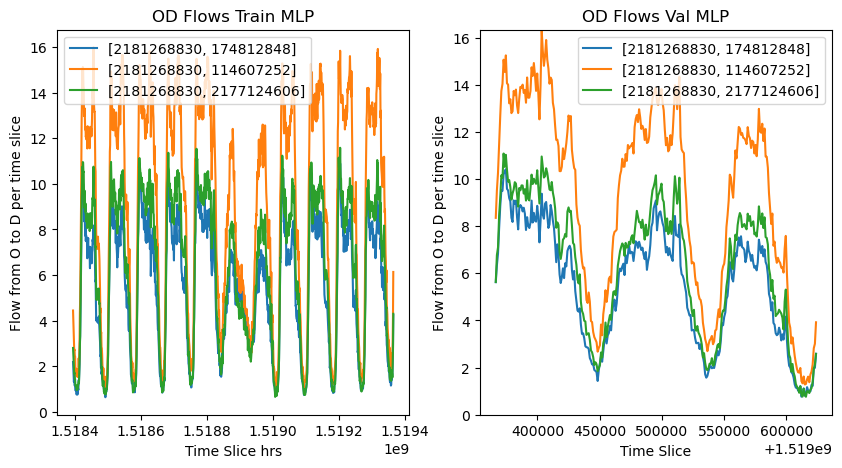

In [340]:
#xx_tr=np.array(range(0,od_flow_matrix_train_ml.shape[1]))/4.
xx_tr=counts_time[0:i_tr]
#xx_val=np.array(range(0,od_flow_matrix_val_ml.shape[1]))/4.
xx_val=counts_time[i_tr+1:i_va]
ymax=0
fig,ax=plt.subplots(1,2,figsize=(10,5))
for ii in range(232,235):#range(counts.shape[0]):
    y=od_flow_matrix_train_ml[ii,:]
    y[np.where(np.isnan(y))]=0
    if(ymax < np.max(y)):
        ymax=np.max(y)
    ax[0].plot(xx_tr,od_flow_matrix_train_ml[ii,:], label=str(list(od_pairs[ii])))
plt.ylim(0,ymax)
ax[0].set_xlabel("Time Slice hrs")
ax[0].set_ylabel("Flow from O to D per time slice")
ax[0].legend()
ax[0].title.set_text("OD Flows Train MLP")

for ii in range(232,235):#range(counts.shape[0]):
    y=od_flow_matrix_val_ml[ii,:]
    y[np.where(np.isnan(y))]=0
    if(ymax < np.max(y)):
        ymax=np.max(y)
    ax[1].plot(xx_val,od_flow_matrix_val_ml[ii,:], label=str(list(od_pairs[ii])))
plt.ylim(0,ymax)
plt.xlabel("Time Slice")
plt.ylabel("Flow from O to D per time slice")
plt.legend()
plt.title("OD Flows Val MLP")
plt.savefig(data_dir+"/OSM/"+city+"/"+modelname+"_ODflows.png")
plt.show()
plt.close()

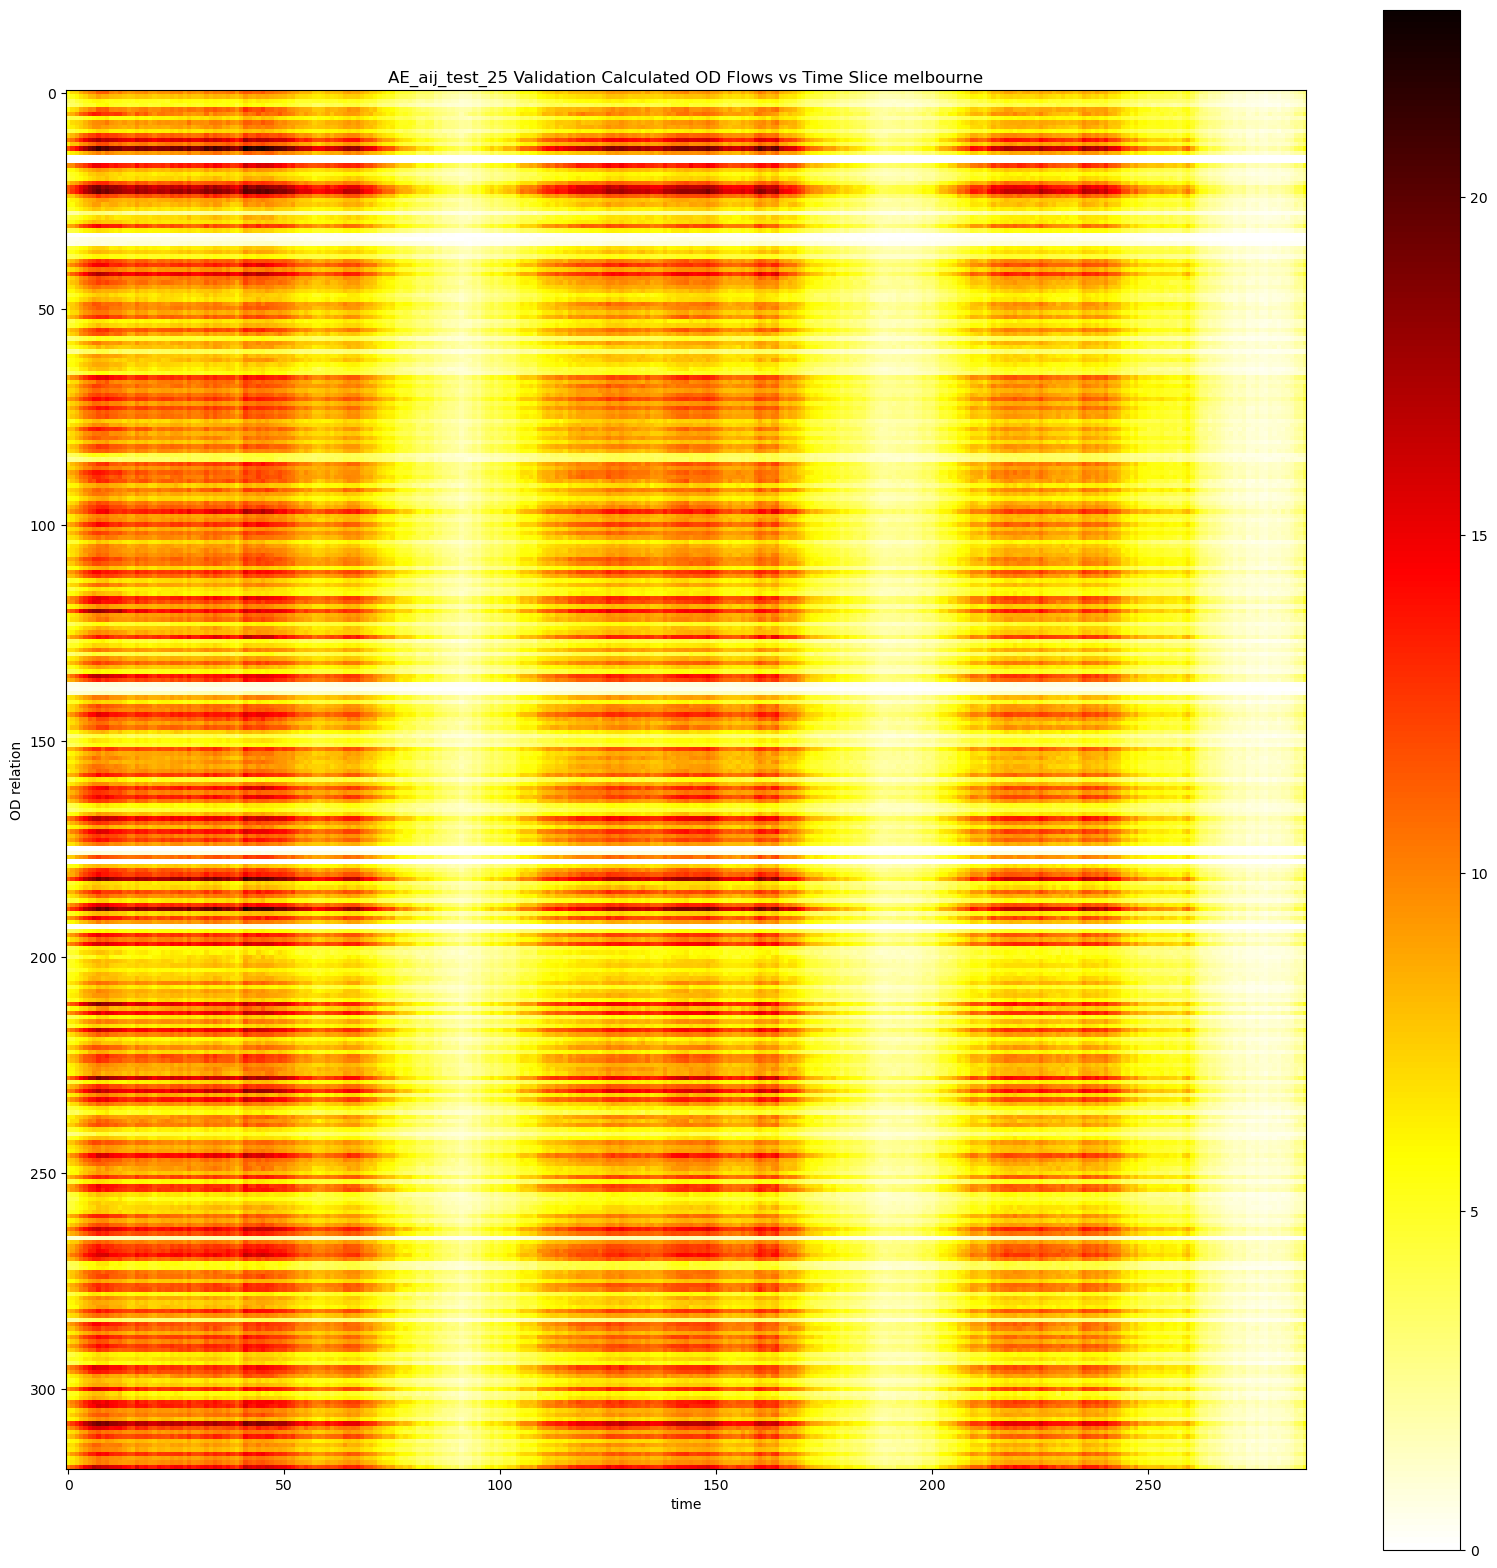

In [341]:
fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(od_flow_matrix_val_ml, cmap='hot_r', interpolation='nearest',vmin=0, vmax=np.max(od_flow_matrix_val_ml))

ax.title.set_text('Time 30')
ax.set_ylabel("OD relation")
ax.set_xlabel("time")

plt.title(modelname + " Validation Calculated OD Flows vs Time Slice "+ city)
plt.colorbar(im)
plt.savefig(data_dir+"/OSM/"+city+"/"+modelname+"_ODFLow_val_heat.png")
plt.show()
plt.close()

# Issues: many 0-value route flows from MLP
### These are centrally-located nodes which are on routes, random which ones though
### Layer Bias = True
- Setting layer bias to true improves agreement with counts and there are fewer 0-value route flows
### Decrease learning rate
- 1e-6 needs 2000 epochs, 5/16 0-values if left to minimize loss (only 2 if 1000 epochs but not min loss)
### Increase learning rate
- 1e-2 fast learning drop in 3 epochs, bumps 5,40 epochs, still 0-value route flows
### Shuffle counts input with Dataloader does this affect order of X outputs?
- Something is really wrong with this result as the counts now also have zeroes
### L1 loss instead of MLE (L2)
- A less-even decrease in loss, slower loss decline, still 5 0-value routes just different ones
- Note L1-loss is "built in" to the system (Krzhansky)
### L1-Regularization with MSE (Lasso), sweep lambda
- As in CompressedSensing_1.ipynb
- Regularization is suited for sparse solution
- Best lambda 0.01: best loss also gives fewest zero-value route flows
### Forcing NN to integer-value solutions
- Gradients would be unpredictable
- Round off float results?
- Constrain model and input to UINT for inference on CPU but no training
- Logit/Sigmoid output layer for categorical int output

In [ ]:
def run_model(l1_lambda):
# Prepare  dataset

#trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)

    ytrain=torch.from_numpy(counts).float().to(torch_device)# leaf, not requires grad
    print(f"ytrain is on device: {ytrain.get_device()}")
    trainloader = torch.utils.data.DataLoader(ytrain.T)
#trainloader = torch.utils.data.DataLoader(ytrain.T, batch_size=1, shuffle=False, num_workers=1)


#print(f"ytrain {ytrain.grad_fn} {ytrain.is_leaf}")

# Initialize the MLP
#mlp=MLP(ysize,xsize,l1size,l2size)
    mlp=MLP()
    mlp.to(torch_device)
  #  print(f"mlp is on device: {next(mlp.parameters()).device}")

  #  print(mlp)

# Define the loss function and optimizer
    loss_function = nn.MSELoss()
#loss_function = nn.L1Loss()

    optimizer = torch.optim.Adam(mlp.parameters(), lr=lrate)
#optimizer = torch.optim.SGD(mlp.parameters(), lr=lrate)

# Run the training loop

    loss_trace=[]
    avloss_trace=[]
    yhats=counts.T*0.
    out_cpu=x.value.T*0
    
    for epoch in range(0, n_epochs): # 5 epochs at maximum
        batch_loss=0.  
  # Print epoch
  #if(epoch % 100 == 0):
        #print(f'Starting epoch {epoch+1}')
    
# Train
        for i, data in enumerate(trainloader):# iterate through time steps

            inputs = data.float() # there are no targets/labels
    #print(f"inputs on device: {inputs.get_device()}")
            inputs = inputs.to(torch_device)
    #print(f"inputs cast to device: {inputs.get_device()}")
   
  # Zero the gradients
            optimizer.zero_grad()
      
  # Perform forward pass
    #print(f"ytrain[:,i] {ytrain[:,i].grad_fn} {ytrain[:,i].is_leaf}")
            outputs = mlp(inputs)
  
            Atorch=torch.from_numpy(aij.T).float().to(torch_device) # Transpose adjacency matrix
    
  # Calculate loss
            yhat = (outputs @ Atorch).to(torch_device)# grad, no leaf

  #yhat = torch.tensor(Atorch @ outputs,dtype=torch.float,requires_grad=True).to(device)# no grad, leaf
  #print(f"outputs {outputs.grad_fn} {outputs.is_leaf}")
   # print(f"yhat {yhat.grad_fn} {yhat.is_leaf}")

            loss = loss_function(yhat,inputs)
  # L1 regularization
            l1_norm = sum(torch.linalg.norm(p, 1) for p in mlp.parameters())
            loss = loss + l1_lambda * l1_norm
  #loss=loss_function(outputs,targets)
  
# Perform backward pass
            loss.backward()

# Perform optimization
            optimizer.step()
      
  # Print statistics
            batch_loss += loss.item()
            loss_trace.append(loss.item())
    #print(loss.item())

            if(epoch==n_epochs-1):
                yhats[i,:]=yhat.detach().cpu().numpy()
                out_cpu[i,:]=outputs.detach().cpu().numpy()
        avloss_trace.append(batch_loss/i)
# Process is complete.
    print("Done training")
    return(avloss_trace, yhats, out_cpu)

### Sweep over lambdas for L1 Norm weight

In [ ]:
#minloss=9999999.
#for i in range(-5,3):
#    l1_lambda=10.**i
#    v1,v2,v3=run_model(l1_lambda)
#    if(np.min(v1)<minloss):
#        minloss=np.min(v1)
#        minlambda=l1_lambda
#        print(f"minloss {minloss} minlambda {minlambda}")

# Best lamdba is 0.01
# Check that the MLP has learned itself out with the final lambda

In [ ]:
#plt.plot(range(5*n_epochs),loss_trace)
plt.plot(range(n_epochs),v1)
plt.title(plttitle)
plt.ylabel("Batch Loss")
plt.xlabel("Epoch")

In [ ]:
print((np.sum(yval.detach().cpu().numpy())-np.sum(yhats_val))/(np.sum(yval.detach().cpu().numpy())))